<a href="https://colab.research.google.com/github/nitaifingerhut/cs236608/blob/master/project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reclab installation. This may take a minute or two
!pip install pybind11
!pip install reclab[recommenders]
!cp /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.cpython-36m-x86_64-linux-gnu.so /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.so
!git clone https://github.com/berkeley-reclab/RecLab /usr/local/lib/python3.7/dist-packages/reclab2
!cp -a /usr/local/lib/python3.7/dist-packages/reclab2/reclab/recommenders/. /usr/local/lib/python3.7/dist-packages/reclab/recommenders/

fatal: destination path '/usr/local/lib/python3.7/dist-packages/reclab2' already exists and is not an empty directory.


In [2]:
import scipy.sparse
import wpyfm
from reclab.recommenders.libfm import LibFM

class LibFM_MLHB(LibFM):
  def _predict(self, user_item):  # noqa: D102
    # Create a test_inputs array that can be parsed by our output function.
    test_inputs = []
    data = []
    row_col = [[], []]
    for row, (user_id, item_id, rating_context) in enumerate(user_item):
        user_features = self._users[user_id]
        item_features = self._items[item_id]
        row_col[0].append(row)
        row_col[1].append(user_id)
        data.append(1)
        for i, feature in enumerate(user_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + i)
            data.append(feature)
        row_col[0].append(row)
        row_col[1].append(self._max_num_users + len(user_features) + item_id)
        data.append(1)
        for i, feature in enumerate(item_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + i)
            data.append(feature)
        for i, feature in enumerate(rating_context):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + len(item_features) + i)
            data.append(feature)

    test_inputs = scipy.sparse.csr_matrix((data, row_col),
                                          shape=(len(user_item), self._num_features))
    test_data = wpyfm.Data(test_inputs, np.zeros(test_inputs.shape[0]), has_xt=self._has_xt)
    predictions = self._model.predict(test_data)

    return predictions

  def reset(self, users=None, items=None, ratings=None):  # noqa: D102
    rating_inputs = scipy.sparse.csr_matrix((0, self._num_features))
    rating_outputs = np.empty((0,))
    self._train_data = wpyfm.Data(rating_inputs, rating_outputs, has_xt=self._has_xt)
    super().reset(users, items, ratings)
    self._model.train(self._train_data)

In [3]:
import numpy as np
import reclab
from reclab.environments import Topics
from reclab.recommenders.libfm import LibFM
from reclab.recommenders import RandomRec, TopPop, KNNRecommender, Autorec

NUM_USERS         = 100
NUM_ITEMS         = 100
NUM_TOPICS        = 10
RATING_FREQ       = 0.2
NUM_INIT_RATINGS  = NUM_USERS * NUM_ITEMS // 5

env_params = {
    'num_topics':       NUM_TOPICS,
    'num_users':        NUM_USERS,
    'num_items':        NUM_ITEMS,
    'rating_frequency': RATING_FREQ,
    'num_init_ratings': NUM_INIT_RATINGS,
    'noise':            0.0,
}

env = Topics(**env_params)

SEED = 42

env.seed(SEED)

NUM_USER_FEATURES   = 0
NUM_ITEM_FEATURES   = 0
NUM_RATING_FEATURES = 0

rec_params = {
    'num_user_features':    NUM_USER_FEATURES,
    'num_item_features':    NUM_ITEM_FEATURES,
    'num_rating_features':  NUM_RATING_FEATURES,
    'max_num_users':        NUM_USERS,
    'max_num_items':        NUM_ITEMS,
    'seed':                 SEED,
}

recommender = LibFM_MLHB(**rec_params)

In [4]:
def RMSE_func(env, recommender):
  true_ratings = env.dense_ratings
  predicted_ratings = recommender.dense_predictions
  return np.sqrt(np.mean((predicted_ratings-true_ratings)**2))

def ARRI_func(env, recommender):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  true_ratings = env.dense_ratings
  return np.mean(true_ratings[np.arange(len(all_users)), np.squeeze(recommendations)])

In [5]:
from tqdm import tqdm

def simulation(env, recommender, steps, rpu, retrain=True, callbacks=None, reset=True, seed=0):
  if reset:
    env.seed(seed)
    if hasattr(env, '_topic_change'):
      temp = env._topic_change # Specificaly for topics.
      env._topic_change = 0
      #items, users, ratings = env.reset()  # Wrong order of return values (manorz, Jan 01)
      users, items, ratings = env.reset()
      env._topic_change = temp
    elif hasattr(env, '_affinity_change '):
      temp = env._affinity_change  # Specificaly for latent factor.
      env._affinity_change = 0
      # items, users, ratings = env.reset()
      users, items, ratings = env.reset()
      env._affinity_change = temp
    else:
      # items, users, ratings = env.reset()
      users, items, ratings = env.reset()
    
    recommender.reset(items, users, ratings)

  results = None
  if callbacks is not None:
    results = [[] for _ in callbacks]
    
  for i in tqdm(range(steps)):
    if callbacks is not None:
      for j, callback in enumerate(callbacks):
        res = callback(env, recommender)
        results[j].append(res)

    online_users = env.online_users
    recommendations, predicted_ratings = recommender.recommend(online_users, rpu)
    _, _, ratings, _ = env.step(recommendations)
    recommender.update(ratings=ratings)

    if retrain and hasattr(recommender, '_model'):
        recommender._model.train(recommender._train_data) # Specificaly for libfm.
  return results

In [6]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def plot_graphs(*lists, title, legend=False, label=None, show=False, save=False):
  fig, ax = plt.subplots()
  for i, l in enumerate(lists):
    ax.plot(
        np.arange(len(l)),
        l,
        '.-',
        label=(str(i+1) if label is None else label[i])
    )
  ax.set_xlabel(r'$timestep$')
  ax.set_title(title)
  if legend:
    ax.legend()

  if save:
    plt.savefig(title + '.png')

  if show:
    plt.show()
  else:
    plt.close()

In [7]:
import pandas as pd
import re

def experiment(env_params, recommender, steps, repeats, rpu, retrain=True, callbacks=None, reset=True, **kwargs):
  callbacks_names = [c.__name__ for c in callbacks]
  callbacks_names = [c[:-5] for c in callbacks_names if c.endswith('_func')]

  if len(kwargs) != 0:
    k = list(kwargs.keys())[0]
    v = list(kwargs.values())[0]
    print(f"{k}: {v}")
  
  callbacks_res = {n: {vv: [] for vv in v} for n in callbacks_names}
  print(callbacks_res)

  if len(kwargs) != 0:
    for vv in v:
      env_params[k] = vv
      env = Topics(**env_params)
      for r in range(repeats):
        print(f'running simulation with {k}={vv}, repeat {r}')
        _res = simulation(env, recommender, steps, rpu, retrain, callbacks, reset, r)
        for i, n in enumerate(callbacks_names):
          callbacks_res[n][vv].append(_res[i])
      
      for i, n in enumerate(callbacks_names):
        callbacks_res[n][vv] = list(np.mean(np.asarray(callbacks_res[n][vv]), axis=0))
    
  return callbacks_res        

In [28]:
def ARRI_func(env, recommender):
  """env.dense_ratings doesn't clip the ratings in [1, 5], so for each user and recommended item we get the correct clipped rating."""
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  true_ratings = []
  for user_id, item_id in zip(np.arange(len(all_users)), recommendations):
    user_rating = env._get_rating(user_id, item_id)
    true_ratings.append(user_rating)
  return np.mean(user_rating)

In [26]:
STEPS =     100
RPU   =     1
RETRAIN =   True
RESET =     True
CALLBACKS = [RMSE_func, ARRI_func]

RMSE, ARRI = simulation(env, recommender, STEPS, RPU, RETRAIN, CALLBACKS, RESET, SEED)

100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


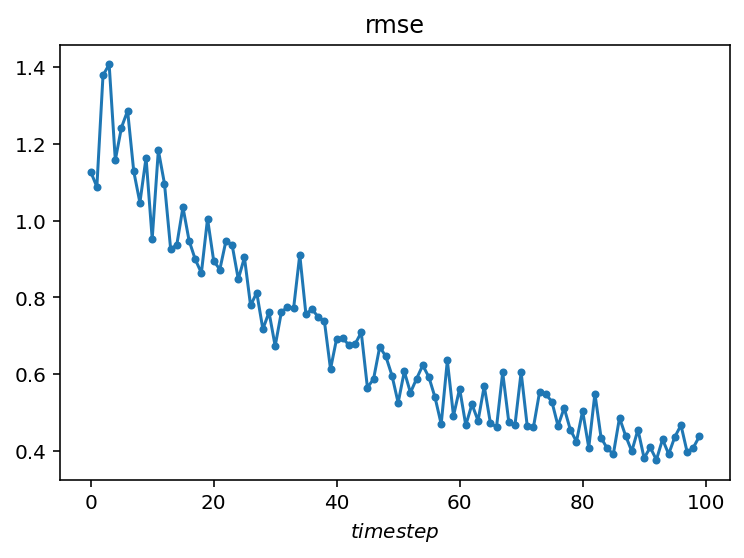

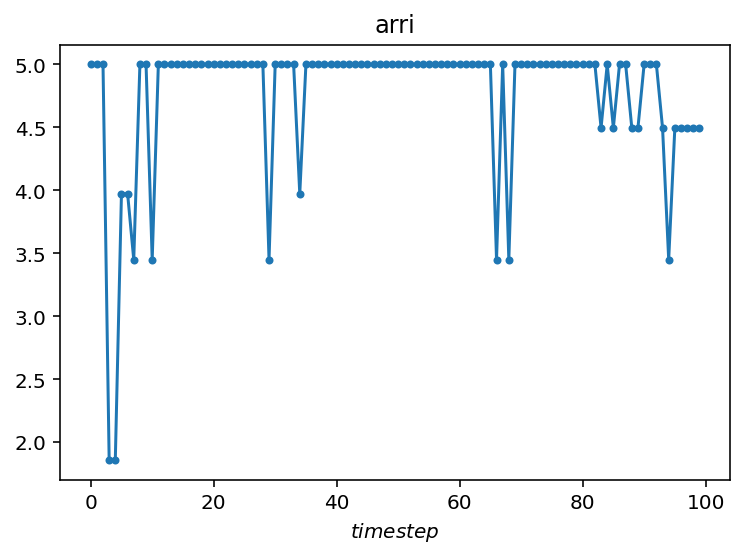

In [27]:
plot_graphs(RMSE, title="rmse", show=True, save=True)
plot_graphs(ARRI, title="arri", show=True, save=True)

In [11]:
REPEATS = 1

res = experiment(env_params, recommender, STEPS, REPEATS, RPU, RETRAIN, CALLBACKS, RESET, topic_change=[0])

topic_change: [0]
{'RMSE': {0: []}, 'ARRI': {0: []}}
running simulation with topic_change=0, repeat 0


  1%|          | 1/100 [00:00<00:21,  4.50it/s]

[[81]
 [71]
 [43]
 [48]
 [73]
 [29]
 [19]
 [99]
 [16]
 [89]
 [44]
 [48]
 [62]
 [40]
 [71]
 [10]
 [60]
 [65]
 [ 6]
 [70]
 [76]
 [91]
 [56]
 [33]
 [62]
 [34]
 [26]
 [97]
 [99]
 [55]
 [ 7]
 [74]
 [26]
 [26]
 [ 4]
 [27]
 [82]
 [54]
 [74]
 [91]
 [25]
 [42]
 [ 3]
 [82]
 [32]
 [ 3]
 [51]
 [26]
 [71]
 [20]
 [88]
 [11]
 [44]
 [ 6]
 [99]
 [74]
 [44]
 [94]
 [20]
 [31]
 [62]
 [88]
 [97]
 [81]
 [ 7]
 [28]
 [61]
 [ 3]
 [51]
 [90]
 [76]
 [62]
 [81]
 [26]
 [23]
 [91]
 [90]
 [48]
 [62]
 [28]
 [66]
 [11]
 [65]
 [42]
 [20]
 [90]
 [36]
 [50]
 [ 5]
 [73]
 [ 8]
 [12]
 [56]
 [58]
 [82]
 [ 2]
 [62]
 [68]
 [85]
 [ 0]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

  2%|▏         | 2/100 [00:00<00:22,  4.44it/s]

[[17]
 [56]
 [62]
 [73]
 [92]
 [50]
 [48]
 [60]
 [34]
 [44]
 [85]
 [81]
 [63]
 [89]
 [93]
 [62]
 [28]
 [ 6]
 [ 6]
 [76]
 [76]
 [29]
 [55]
 [26]
 [73]
 [98]
 [56]
 [12]
 [26]
 [10]
 [72]
 [87]
 [73]
 [42]
 [17]
 [57]
 [10]
 [46]
 [ 2]
 [60]
 [71]
 [42]
 [89]
 [62]
 [54]
 [99]
 [69]
 [39]
 [61]
 [50]
 [ 2]
 [73]
 [11]
 [17]
 [25]
 [69]
 [ 3]
 [43]
 [34]
 [49]
 [85]
 [51]
 [54]
 [27]
 [16]
 [27]
 [82]
 [34]
 [10]
 [69]
 [76]
 [62]
 [69]
 [18]
 [32]
 [31]
 [10]
 [25]
 [85]
 [10]
 [34]
 [25]
 [57]
 [62]
 [76]
 [29]
 [32]
 [58]
 [42]
 [17]
 [ 3]
 [61]
 [70]
 [36]
 [73]
 [13]
 [17]
 [43]
 [45]
 [25]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

  3%|▎         | 3/100 [00:00<00:20,  4.67it/s]

[[23]
 [ 6]
 [91]
 [82]
 [10]
 [ 7]
 [25]
 [36]
 [92]
 [18]
 [57]
 [33]
 [62]
 [27]
 [36]
 [25]
 [60]
 [86]
 [21]
 [42]
 [20]
 [64]
 [39]
 [64]
 [59]
 [34]
 [44]
 [64]
 [26]
 [39]
 [12]
 [14]
 [84]
 [86]
 [62]
 [ 2]
 [98]
 [40]
 [59]
 [76]
 [38]
 [76]
 [91]
 [13]
 [54]
 [ 4]
 [93]
 [39]
 [56]
 [70]
 [10]
 [73]
 [11]
 [26]
 [62]
 [86]
 [68]
 [30]
 [42]
 [99]
 [73]
 [27]
 [31]
 [42]
 [91]
 [42]
 [38]
 [21]
 [98]
 [12]
 [76]
 [76]
 [60]
 [64]
 [82]
 [63]
 [34]
 [28]
 [24]
 [ 4]
 [26]
 [40]
 [84]
 [68]
 [ 2]
 [71]
 [49]
 [39]
 [42]
 [62]
 [28]
 [74]
 [80]
 [94]
 [27]
 [37]
 [65]
 [42]
 [21]
 [86]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

  4%|▍         | 4/100 [00:00<00:20,  4.68it/s]

[[35]
 [89]
 [ 0]
 [51]
 [72]
 [79]
 [70]
 [72]
 [62]
 [69]
 [ 1]
 [48]
 [59]
 [69]
 [65]
 [57]
 [69]
 [17]
 [65]
 [ 4]
 [61]
 [40]
 [11]
 [62]
 [22]
 [89]
 [56]
 [90]
 [62]
 [61]
 [42]
 [39]
 [57]
 [44]
 [62]
 [ 9]
 [31]
 [61]
 [42]
 [57]
 [88]
 [62]
 [49]
 [48]
 [71]
 [55]
 [26]
 [23]
 [32]
 [25]
 [52]
 [ 3]
 [65]
 [62]
 [68]
 [35]
 [ 9]
 [73]
 [69]
 [10]
 [89]
 [51]
 [95]
 [15]
 [76]
 [42]
 [13]
 [68]
 [35]
 [29]
 [20]
 [62]
 [89]
 [40]
 [14]
 [85]
 [28]
 [39]
 [85]
 [46]
 [89]
 [80]
 [65]
 [42]
 [97]
 [ 6]
 [16]
 [74]
 [36]
 [62]
 [75]
 [79]
 [73]
 [45]
 [35]
 [37]
 [44]
 [54]
 [62]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

  6%|▌         | 6/100 [00:01<00:19,  4.76it/s]

[[10]
 [44]
 [26]
 [53]
 [83]
 [78]
 [23]
 [96]
 [20]
 [34]
 [40]
 [53]
 [83]
 [23]
 [10]
 [10]
 [93]
 [27]
 [38]
 [76]
 [40]
 [26]
 [99]
 [10]
 [87]
 [26]
 [74]
 [12]
 [40]
 [84]
 [26]
 [16]
 [65]
 [21]
 [56]
 [96]
 [75]
 [26]
 [ 1]
 [11]
 [38]
 [ 2]
 [81]
 [98]
 [69]
 [41]
 [23]
 [75]
 [ 9]
 [59]
 [76]
 [34]
 [65]
 [14]
 [94]
 [87]
 [52]
 [96]
 [40]
 [22]
 [62]
 [27]
 [28]
 [76]
 [35]
 [87]
 [69]
 [34]
 [39]
 [45]
 [69]
 [23]
 [10]
 [10]
 [49]
 [63]
 [ 5]
 [96]
 [50]
 [ 4]
 [20]
 [64]
 [60]
 [25]
 [76]
 [66]
 [19]
 [40]
 [69]
 [58]
 [21]
 [27]
 [44]
 [10]
 [64]
 [82]
 [43]
 [50]
 [45]
 [25]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

  7%|▋         | 7/100 [00:01<00:19,  4.72it/s]

[[13]
 [76]
 [19]
 [73]
 [27]
 [ 7]
 [ 6]
 [40]
 [20]
 [70]
 [71]
 [ 4]
 [83]
 [42]
 [47]
 [91]
 [57]
 [11]
 [64]
 [20]
 [64]
 [ 7]
 [14]
 [64]
 [22]
 [48]
 [71]
 [70]
 [81]
 [39]
 [47]
 [89]
 [64]
 [91]
 [77]
 [ 1]
 [81]
 [83]
 [21]
 [70]
 [82]
 [71]
 [35]
 [23]
 [72]
 [75]
 [16]
 [92]
 [33]
 [70]
 [60]
 [62]
 [46]
 [13]
 [76]
 [65]
 [25]
 [90]
 [27]
 [78]
 [88]
 [62]
 [17]
 [33]
 [42]
 [10]
 [62]
 [84]
 [51]
 [22]
 [62]
 [20]
 [25]
 [40]
 [86]
 [92]
 [42]
 [77]
 [27]
 [30]
 [88]
 [73]
 [11]
 [42]
 [76]
 [91]
 [94]
 [74]
 [42]
 [84]
 [68]
 [16]
 [52]
 [52]
 [55]
 [26]
 [71]
 [85]
 [87]
 [ 6]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

  8%|▊         | 8/100 [00:01<00:19,  4.80it/s]

[[40]
 [64]
 [ 6]
 [13]
 [60]
 [79]
 [26]
 [63]
 [26]
 [53]
 [25]
 [ 4]
 [91]
 [40]
 [97]
 [88]
 [77]
 [53]
 [41]
 [ 4]
 [51]
 [94]
 [99]
 [62]
 [85]
 [19]
 [78]
 [78]
 [54]
 [51]
 [47]
 [39]
 [42]
 [89]
 [ 1]
 [42]
 [51]
 [73]
 [83]
 [57]
 [30]
 [42]
 [45]
 [48]
 [97]
 [99]
 [84]
 [39]
 [19]
 [95]
 [91]
 [77]
 [40]
 [40]
 [89]
 [64]
 [35]
 [42]
 [ 4]
 [ 1]
 [54]
 [32]
 [ 6]
 [88]
 [ 9]
 [ 4]
 [33]
 [73]
 [73]
 [36]
 [73]
 [27]
 [27]
 [60]
 [48]
 [91]
 [90]
 [ 5]
 [56]
 [88]
 [66]
 [13]
 [26]
 [76]
 [73]
 [ 5]
 [47]
 [62]
 [62]
 [91]
 [18]
 [77]
 [13]
 [42]
 [66]
 [10]
 [ 6]
 [31]
 [34]
 [26]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

  9%|▉         | 9/100 [00:01<00:19,  4.74it/s]

[[13]
 [ 6]
 [22]
 [35]
 [62]
 [79]
 [62]
 [12]
 [61]
 [38]
 [50]
 [34]
 [83]
 [26]
 [12]
 [76]
 [42]
 [46]
 [34]
 [20]
 [26]
 [22]
 [98]
 [62]
 [29]
 [53]
 [18]
 [90]
 [50]
 [40]
 [12]
 [48]
 [91]
 [49]
 [41]
 [91]
 [ 0]
 [65]
 [27]
 [ 1]
 [70]
 [40]
 [60]
 [76]
 [14]
 [91]
 [16]
 [41]
 [51]
 [72]
 [76]
 [ 9]
 [46]
 [62]
 [40]
 [74]
 [16]
 [94]
 [69]
 [22]
 [68]
 [16]
 [57]
 [76]
 [35]
 [91]
 [91]
 [30]
 [67]
 [20]
 [17]
 [23]
 [15]
 [26]
 [55]
 [27]
 [61]
 [68]
 [88]
 [18]
 [91]
 [76]
 [32]
 [26]
 [76]
 [91]
 [48]
 [74]
 [ 4]
 [26]
 [57]
 [47]
 [91]
 [58]
 [82]
 [33]
 [99]
 [72]
 [17]
 [68]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 11%|█         | 11/100 [00:02<00:18,  4.85it/s]

[[62]
 [40]
 [46]
 [64]
 [ 2]
 [ 8]
 [40]
 [87]
 [62]
 [ 2]
 [ 2]
 [40]
 [93]
 [31]
 [20]
 [71]
 [23]
 [51]
 [ 2]
 [75]
 [25]
 [43]
 [88]
 [40]
 [ 1]
 [93]
 [71]
 [22]
 [40]
 [32]
 [94]
 [89]
 [64]
 [81]
 [62]
 [42]
 [77]
 [65]
 [62]
 [70]
 [20]
 [40]
 [26]
 [51]
 [73]
 [55]
 [93]
 [39]
 [ 1]
 [93]
 [ 2]
 [76]
 [64]
 [51]
 [52]
 [69]
 [61]
 [22]
 [26]
 [56]
 [93]
 [59]
 [10]
 [25]
 [82]
 [57]
 [66]
 [91]
 [16]
 [64]
 [26]
 [40]
 [31]
 [26]
 [13]
 [70]
 [30]
 [75]
 [ 2]
 [10]
 [91]
 [40]
 [60]
 [91]
 [69]
 [ 2]
 [43]
 [43]
 [68]
 [51]
 [30]
 [40]
 [27]
 [90]
 [42]
 [99]
 [51]
 [68]
 [26]
 [69]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 12%|█▏        | 12/100 [00:02<00:17,  4.91it/s]

[[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.98838184 ... 3.03431479 1.64323275 2.11414769]]
[[48]
 [ 2]
 [96]
 [53]
 [79]
 [92]
 [46]
 [96]
 [26]
 [ 2]
 [97]
 [88]
 [ 8]
 [46]
 [20]
 [88]
 [77]
 [23]
 [41]
 [62]
 [82]
 [58]
 [76]
 [50]
 [91]
 [30]
 [78]
 [80]
 [ 0]
 [ 6]
 [29]
 [69]
 [26]
 [62]
 [20]
 [42]
 [53]
 [83]
 [ 1]
 [76]
 [73]
 [62]
 [38]
 [ 9]
 [61]
 [55]
 [16]
 [33]
 [32]
 [63]
 [10]
 [ 8]
 [45]
 [76]
 [26]
 [ 1]
 [10]
 [26]
 [62]
 [49]
 [59]
 [20]
 [21]
 [76]
 [88]
 [62]
 [62]
 [68]
 [ 2]
 [36]
 [26]
 [84]
 [91]
 [23]
 [ 9]
 [92]
 [21]
 [42]
 [85]
 [60]
 [93]
 [ 9]
 [ 6]
 [64]
 [10]
 [95]
 [49]
 [39]
 [26]
 [ 9]
 [77]
 [72]
 [71

 14%|█▍        | 14/100 [00:02<00:17,  4.95it/s]

[[62]
 [ 6]
 [ 6]
 [98]
 [88]
 [ 7]
 [16]
 [50]
 [80]
 [83]
 [50]
 [88]
 [ 1]
 [ 6]
 [ 2]
 [44]
 [88]
 [65]
 [28]
 [ 5]
 [62]
 [43]
 [56]
 [62]
 [50]
 [21]
 [76]
 [84]
 [88]
 [ 8]
 [74]
 [36]
 [91]
 [23]
 [ 9]
 [ 9]
 [19]
 [50]
 [76]
 [18]
 [15]
 [84]
 [54]
 [88]
 [16]
 [ 4]
 [62]
 [62]
 [84]
 [25]
 [44]
 [ 3]
 [56]
 [62]
 [76]
 [42]
 [78]
 [43]
 [76]
 [49]
 [57]
 [90]
 [19]
 [76]
 [96]
 [80]
 [39]
 [54]
 [98]
 [91]
 [ 9]
 [84]
 [55]
 [74]
 [48]
 [25]
 [57]
 [21]
 [50]
 [ 4]
 [62]
 [ 2]
 [97]
 [36]
 [56]
 [11]
 [88]
 [74]
 [77]
 [ 9]
 [96]
 [89]
 [76]
 [27]
 [ 2]
 [66]
 [84]
 [20]
 [85]
 [30]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 15%|█▌        | 15/100 [00:03<00:17,  4.93it/s]

[[67]
 [45]
 [22]
 [98]
 [52]
 [ 7]
 [84]
 [ 7]
 [26]
 [95]
 [97]
 [82]
 [ 8]
 [16]
 [23]
 [52]
 [30]
 [17]
 [77]
 [75]
 [26]
 [45]
 [25]
 [62]
 [12]
 [13]
 [56]
 [ 2]
 [88]
 [62]
 [58]
 [61]
 [26]
 [75]
 [20]
 [91]
 [33]
 [65]
 [ 3]
 [40]
 [88]
 [76]
 [12]
 [16]
 [82]
 [34]
 [23]
 [53]
 [14]
 [92]
 [91]
 [62]
 [86]
 [62]
 [28]
 [12]
 [76]
 [43]
 [26]
 [38]
 [30]
 [73]
 [76]
 [10]
 [35]
 [30]
 [37]
 [75]
 [39]
 [20]
 [26]
 [82]
 [27]
 [52]
 [64]
 [83]
 [53]
 [41]
 [44]
 [95]
 [48]
 [76]
 [57]
 [73]
 [78]
 [58]
 [82]
 [43]
 [64]
 [76]
 [52]
 [63]
 [97]
 [29]
 [76]
 [33]
 [76]
 [77]
 [22]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 16%|█▌        | 16/100 [00:03<00:17,  4.88it/s]

[[88]
 [84]
 [56]
 [61]
 [88]
 [83]
 [ 6]
 [92]
 [97]
 [25]
 [20]
 [98]
 [40]
 [11]
 [45]
 [82]
 [31]
 [46]
 [21]
 [ 3]
 [69]
 [40]
 [19]
 [62]
 [91]
 [15]
 [84]
 [76]
 [66]
 [35]
 [36]
 [40]
 [ 2]
 [76]
 [69]
 [40]
 [53]
 [85]
 [50]
 [52]
 [80]
 [42]
 [13]
 [72]
 [55]
 [26]
 [13]
 [71]
 [88]
 [63]
 [ 2]
 [25]
 [76]
 [86]
 [95]
 [98]
 [11]
 [68]
 [40]
 [79]
 [88]
 [51]
 [21]
 [79]
 [17]
 [77]
 [55]
 [ 3]
 [35]
 [36]
 [86]
 [73]
 [ 0]
 [10]
 [72]
 [92]
 [48]
 [ 5]
 [50]
 [95]
 [69]
 [46]
 [11]
 [76]
 [42]
 [ 3]
 [61]
 [35]
 [95]
 [ 1]
 [96]
 [21]
 [44]
 [29]
 [69]
 [13]
 [76]
 [59]
 [26]
 [23]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 18%|█▊        | 18/100 [00:03<00:16,  4.88it/s]

[[64]
 [40]
 [86]
 [13]
 [77]
 [79]
 [53]
 [ 7]
 [80]
 [67]
 [26]
 [32]
 [ 8]
 [84]
 [45]
 [15]
 [10]
 [17]
 [46]
 [41]
 [26]
 [74]
 [ 2]
 [79]
 [94]
 [34]
 [27]
 [82]
 [66]
 [83]
 [43]
 [16]
 [56]
 [97]
 [20]
 [42]
 [10]
 [26]
 [42]
 [52]
 [76]
 [73]
 [ 0]
 [ 9]
 [51]
 [ 5]
 [16]
 [82]
 [86]
 [60]
 [ 1]
 [ 1]
 [86]
 [ 9]
 [64]
 [73]
 [14]
 [84]
 [26]
 [99]
 [63]
 [63]
 [28]
 [18]
 [49]
 [ 4]
 [66]
 [30]
 [48]
 [42]
 [26]
 [73]
 [49]
 [27]
 [55]
 [ 1]
 [ 3]
 [42]
 [18]
 [57]
 [35]
 [ 9]
 [65]
 [76]
 [97]
 [91]
 [29]
 [90]
 [36]
 [ 9]
 [31]
 [ 5]
 [70]
 [74]
 [76]
 [37]
 [84]
 [40]
 [ 1]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 19%|█▉        | 19/100 [00:03<00:16,  4.83it/s]

[[16]
 [70]
 [43]
 [53]
 [10]
 [40]
 [86]
 [50]
 [63]
 [25]
 [40]
 [34]
 [78]
 [89]
 [36]
 [88]
 [27]
 [68]
 [10]
 [10]
 [ 1]
 [96]
 [16]
 [ 1]
 [12]
 [15]
 [12]
 [60]
 [ 1]
 [89]
 [78]
 [16]
 [ 1]
 [81]
 [68]
 [40]
 [51]
 [74]
 [20]
 [56]
 [88]
 [ 1]
 [28]
 [93]
 [42]
 [75]
 [89]
 [ 3]
 [19]
 [40]
 [40]
 [40]
 [70]
 [ 6]
 [68]
 [42]
 [27]
 [ 1]
 [ 1]
 [78]
 [24]
 [93]
 [78]
 [18]
 [24]
 [69]
 [53]
 [ 1]
 [48]
 [12]
 [69]
 [20]
 [81]
 [10]
 [49]
 [ 1]
 [42]
 [68]
 [24]
 [84]
 [ 1]
 [ 9]
 [68]
 [ 3]
 [57]
 [78]
 [12]
 [94]
 [20]
 [25]
 [ 3]
 [79]
 [60]
 [94]
 [76]
 [20]
 [84]
 [79]
 [75]
 [10]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 21%|██        | 21/100 [00:04<00:16,  4.82it/s]

[[48]
 [32]
 [12]
 [67]
 [88]
 [79]
 [89]
 [83]
 [26]
 [99]
 [42]
 [48]
 [ 9]
 [52]
 [22]
 [37]
 [49]
 [30]
 [88]
 [75]
 [25]
 [29]
 [25]
 [73]
 [87]
 [99]
 [44]
 [74]
 [33]
 [42]
 [58]
 [89]
 [43]
 [ 2]
 [40]
 [43]
 [28]
 [72]
 [25]
 [56]
 [82]
 [37]
 [76]
 [40]
 [50]
 [20]
 [67]
 [33]
 [64]
 [43]
 [43]
 [37]
 [86]
 [40]
 [26]
 [40]
 [11]
 [30]
 [40]
 [86]
 [40]
 [20]
 [52]
 [81]
 [37]
 [75]
 [37]
 [ 1]
 [40]
 [42]
 [69]
 [73]
 [86]
 [52]
 [49]
 [69]
 [89]
 [95]
 [24]
 [62]
 [40]
 [89]
 [18]
 [26]
 [56]
 [11]
 [52]
 [58]
 [ 1]
 [43]
 [91]
 [30]
 [ 9]
 [52]
 [49]
 [82]
 [69]
 [59]
 [12]
 [40]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 22%|██▏       | 22/100 [00:04<00:16,  4.83it/s]

[[48]
 [80]
 [84]
 [60]
 [65]
 [71]
 [62]
 [97]
 [40]
 [62]
 [44]
 [76]
 [62]
 [88]
 [88]
 [55]
 [ 5]
 [88]
 [28]
 [75]
 [40]
 [45]
 [49]
 [40]
 [29]
 [53]
 [10]
 [69]
 [ 9]
 [32]
 [90]
 [88]
 [52]
 [75]
 [84]
 [42]
 [48]
 [86]
 [91]
 [60]
 [11]
 [42]
 [36]
 [51]
 [16]
 [ 9]
 [93]
 [77]
 [53]
 [ 8]
 [56]
 [72]
 [38]
 [67]
 [83]
 [90]
 [ 8]
 [64]
 [40]
 [99]
 [ 1]
 [50]
 [52]
 [27]
 [98]
 [69]
 [66]
 [ 9]
 [39]
 [20]
 [69]
 [42]
 [71]
 [ 1]
 [81]
 [63]
 [41]
 [30]
 [57]
 [52]
 [48]
 [62]
 [ 2]
 [24]
 [69]
 [88]
 [99]
 [90]
 [20]
 [82]
 [ 2]
 [74]
 [97]
 [29]
 [62]
 [15]
 [69]
 [28]
 [34]
 [26]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 24%|██▍       | 24/100 [00:04<00:15,  4.90it/s]

[[98]
 [71]
 [26]
 [32]
 [ 1]
 [53]
 [98]
 [68]
 [66]
 [14]
 [76]
 [32]
 [72]
 [ 0]
 [90]
 [88]
 [52]
 [84]
 [ 3]
 [ 1]
 [26]
 [58]
 [ 2]
 [40]
 [87]
 [88]
 [30]
 [89]
 [62]
 [ 9]
 [58]
 [48]
 [60]
 [49]
 [ 9]
 [42]
 [ 1]
 [32]
 [83]
 [76]
 [15]
 [ 1]
 [ 0]
 [53]
 [69]
 [41]
 [53]
 [62]
 [60]
 [62]
 [76]
 [ 1]
 [71]
 [53]
 [68]
 [73]
 [19]
 [ 3]
 [15]
 [10]
 [ 1]
 [42]
 [34]
 [66]
 [51]
 [ 4]
 [89]
 [30]
 [32]
 [42]
 [76]
 [20]
 [91]
 [30]
 [98]
 [10]
 [42]
 [75]
 [83]
 [41]
 [13]
 [70]
 [ 1]
 [ 3]
 [97]
 [74]
 [55]
 [20]
 [69]
 [76]
 [12]
 [12]
 [70]
 [ 2]
 [76]
 [37]
 [69]
 [ 5]
 [85]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 25%|██▌       | 25/100 [00:05<00:15,  4.82it/s]

[[48]
 [25]
 [33]
 [61]
 [ 7]
 [94]
 [62]
 [59]
 [80]
 [57]
 [80]
 [98]
 [ 7]
 [19]
 [47]
 [10]
 [44]
 [86]
 [28]
 [52]
 [26]
 [43]
 [55]
 [79]
 [94]
 [88]
 [56]
 [20]
 [79]
 [72]
 [43]
 [30]
 [19]
 [71]
 [68]
 [40]
 [81]
 [19]
 [63]
 [57]
 [25]
 [52]
 [88]
 [89]
 [46]
 [34]
 [16]
 [75]
 [65]
 [92]
 [27]
 [80]
 [19]
 [40]
 [28]
 [74]
 [65]
 [58]
 [79]
 [79]
 [85]
 [54]
 [ 2]
 [80]
 [99]
 [77]
 [99]
 [95]
 [25]
 [35]
 [29]
 [40]
 [ 6]
 [18]
 [15]
 [ 8]
 [69]
 [95]
 [52]
 [75]
 [62]
 [71]
 [92]
 [84]
 [78]
 [91]
 [94]
 [12]
 [64]
 [85]
 [91]
 [ 3]
 [44]
 [36]
 [ 0]
 [40]
 [17]
 [95]
 [29]
 [23]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 26%|██▌       | 26/100 [00:05<00:15,  4.78it/s]

[[67]
 [86]
 [45]
 [32]
 [72]
 [ 8]
 [62]
 [90]
 [50]
 [35]
 [44]
 [33]
 [80]
 [88]
 [23]
 [38]
 [77]
 [97]
 [30]
 [25]
 [26]
 [69]
 [57]
 [73]
 [22]
 [14]
 [25]
 [71]
 [40]
 [35]
 [58]
 [87]
 [11]
 [56]
 [50]
 [40]
 [52]
 [79]
 [59]
 [57]
 [71]
 [69]
 [74]
 [89]
 [80]
 [21]
 [51]
 [17]
 [19]
 [54]
 [27]
 [56]
 [64]
 [73]
 [82]
 [74]
 [26]
 [12]
 [69]
 [10]
 [ 7]
 [73]
 [21]
 [10]
 [33]
 [69]
 [99]
 [ 7]
 [89]
 [22]
 [80]
 [40]
 [84]
 [80]
 [67]
 [92]
 [24]
 [28]
 [24]
 [75]
 [53]
 [40]
 [86]
 [ 6]
 [81]
 [77]
 [15]
 [80]
 [80]
 [80]
 [ 5]
 [58]
 [97]
 [71]
 [88]
 [42]
 [42]
 [34]
 [96]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 27%|██▋       | 27/100 [00:05<00:15,  4.76it/s]

[[67]
 [20]
 [65]
 [32]
 [36]
 [62]
 [32]
 [ 7]
 [54]
 [21]
 [69]
 [49]
 [24]
 [82]
 [20]
 [52]
 [ 2]
 [86]
 [ 3]
 [10]
 [76]
 [91]
 [60]
 [ 1]
 [87]
 [ 4]
 [31]
 [53]
 [55]
 [98]
 [38]
 [87]
 [90]
 [77]
 [80]
 [40]
 [30]
 [65]
 [ 7]
 [60]
 [82]
 [ 1]
 [99]
 [66]
 [59]
 [95]
 [16]
 [71]
 [74]
 [54]
 [91]
 [66]
 [10]
 [76]
 [77]
 [45]
 [78]
 [96]
 [38]
 [46]
 [45]
 [40]
 [ 9]
 [27]
 [73]
 [82]
 [55]
 [34]
 [93]
 [45]
 [86]
 [42]
 [ 6]
 [ 1]
 [15]
 [90]
 [28]
 [76]
 [18]
 [25]
 [98]
 [95]
 [60]
 [23]
 [97]
 [73]
 [14]
 [53]
 [40]
 [15]
 [36]
 [79]
 [80]
 [90]
 [67]
 [51]
 [42]
 [79]
 [68]
 [17]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 28%|██▊       | 28/100 [00:05<00:15,  4.79it/s]

[[16]
 [78]
 [46]
 [19]
 [91]
 [83]
 [64]
 [63]
 [78]
 [95]
 [17]
 [32]
 [24]
 [18]
 [71]
 [88]
 [97]
 [65]
 [28]
 [77]
 [26]
 [74]
 [69]
 [40]
 [45]
 [21]
 [56]
 [71]
 [76]
 [48]
 [45]
 [45]
 [64]
 [18]
 [ 5]
 [91]
 [ 0]
 [64]
 [69]
 [57]
 [71]
 [80]
 [55]
 [33]
 [35]
 [62]
 [23]
 [93]
 [64]
 [ 8]
 [ 2]
 [69]
 [64]
 [19]
 [41]
 [45]
 [ 8]
 [73]
 [69]
 [40]
 [59]
 [42]
 [11]
 [27]
 [73]
 [34]
 [99]
 [76]
 [25]
 [74]
 [33]
 [40]
 [25]
 [12]
 [ 9]
 [73]
 [93]
 [68]
 [59]
 [76]
 [62]
 [71]
 [10]
 [23]
 [76]
 [ 5]
 [99]
 [19]
 [64]
 [76]
 [31]
 [92]
 [91]
 [87]
 [40]
 [ 0]
 [65]
 [28]
 [21]
 [17]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 29%|██▉       | 29/100 [00:06<00:14,  4.80it/s]

[[48]
 [74]
 [10]
 [39]
 [52]
 [62]
 [84]
 [63]
 [54]
 [62]
 [62]
 [76]
 [ 7]
 [76]
 [40]
 [38]
 [34]
 [19]
 [88]
 [34]
 [26]
 [57]
 [51]
 [40]
 [74]
 [28]
 [27]
 [31]
 [38]
 [51]
 [74]
 [61]
 [86]
 [33]
 [21]
 [26]
 [67]
 [65]
 [ 7]
 [11]
 [80]
 [69]
 [55]
 [13]
 [ 6]
 [21]
 [53]
 [30]
 [86]
 [ 8]
 [27]
 [88]
 [64]
 [84]
 [68]
 [42]
 [84]
 [40]
 [26]
 [10]
 [88]
 [ 2]
 [75]
 [10]
 [26]
 [ 1]
 [89]
 [30]
 [89]
 [74]
 [ 1]
 [20]
 [ 9]
 [27]
 [51]
 [69]
 [47]
 [28]
 [62]
 [60]
 [88]
 [78]
 [52]
 [84]
 [37]
 [77]
 [27]
 [12]
 [78]
 [76]
 [30]
 [54]
 [44]
 [ 2]
 [62]
 [66]
 [73]
 [72]
 [41]
 [17]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 30%|███       | 30/100 [00:06<00:14,  4.71it/s]

[[61]
 [ 6]
 [12]
 [32]
 [75]
 [79]
 [46]
 [ 7]
 [79]
 [75]
 [80]
 [76]
 [72]
 [17]
 [12]
 [86]
 [91]
 [62]
 [ 3]
 [75]
 [26]
 [18]
 [49]
 [69]
 [12]
 [95]
 [56]
 [52]
 [17]
 [42]
 [29]
 [76]
 [86]
 [91]
 [21]
 [40]
 [49]
 [19]
 [27]
 [52]
 [95]
 [66]
 [87]
 [ 9]
 [19]
 [76]
 [61]
 [14]
 [61]
 [54]
 [91]
 [69]
 [86]
 [51]
 [86]
 [42]
 [19]
 [22]
 [69]
 [40]
 [54]
 [20]
 [ 1]
 [52]
 [38]
 [76]
 [32]
 [68]
 [89]
 [12]
 [76]
 [69]
 [ 0]
 [ 2]
 [51]
 [18]
 [48]
 [62]
 [80]
 [95]
 [73]
 [75]
 [17]
 [86]
 [31]
 [58]
 [47]
 [67]
 [41]
 [76]
 [57]
 [83]
 [18]
 [94]
 [32]
 [32]
 [ 6]
 [63]
 [68]
 [17]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 31%|███       | 31/100 [00:06<00:14,  4.66it/s]

[[13]
 [70]
 [45]
 [ 2]
 [91]
 [79]
 [25]
 [87]
 [80]
 [97]
 [80]
 [88]
 [ 7]
 [55]
 [91]
 [81]
 [91]
 [19]
 [ 5]
 [34]
 [62]
 [43]
 [10]
 [57]
 [90]
 [48]
 [86]
 [43]
 [25]
 [84]
 [15]
 [93]
 [71]
 [38]
 [21]
 [31]
 [ 0]
 [78]
 [24]
 [52]
 [97]
 [10]
 [ 0]
 [14]
 [53]
 [ 5]
 [93]
 [93]
 [32]
 [50]
 [76]
 [14]
 [70]
 [14]
 [ 3]
 [42]
 [57]
 [65]
 [69]
 [ 2]
 [59]
 [92]
 [30]
 [52]
 [49]
 [21]
 [89]
 [25]
 [93]
 [42]
 [10]
 [69]
 [91]
 [23]
 [49]
 [42]
 [53]
 [95]
 [59]
 [41]
 [67]
 [76]
 [11]
 [62]
 [71]
 [ 3]
 [31]
 [43]
 [40]
 [56]
 [57]
 [47]
 [44]
 [12]
 [76]
 [26]
 [19]
 [24]
 [45]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 32%|███▏      | 32/100 [00:06<00:14,  4.69it/s]

[[61]
 [71]
 [ 6]
 [88]
 [92]
 [88]
 [89]
 [25]
 [26]
 [89]
 [44]
 [28]
 [ 7]
 [14]
 [90]
 [99]
 [57]
 [17]
 [28]
 [95]
 [62]
 [40]
 [80]
 [83]
 [22]
 [99]
 [52]
 [88]
 [72]
 [12]
 [36]
 [98]
 [62]
 [52]
 [28]
 [40]
 [33]
 [54]
 [ 3]
 [11]
 [69]
 [66]
 [14]
 [51]
 [40]
 [99]
 [67]
 [28]
 [14]
 [50]
 [83]
 [41]
 [19]
 [73]
 [ 6]
 [42]
 [79]
 [17]
 [34]
 [49]
 [54]
 [40]
 [ 2]
 [15]
 [ 0]
 [75]
 [98]
 [95]
 [89]
 [74]
 [83]
 [50]
 [64]
 [52]
 [51]
 [44]
 [94]
 [30]
 [71]
 [62]
 [68]
 [70]
 [39]
 [19]
 [52]
 [44]
 [57]
 [45]
 [42]
 [86]
 [30]
 [77]
 [97]
 [58]
 [62]
 [67]
 [73]
 [45]
 [41]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 33%|███▎      | 33/100 [00:06<00:14,  4.73it/s]

[[16]
 [32]
 [18]
 [67]
 [45]
 [83]
 [32]
 [59]
 [62]
 [56]
 [80]
 [98]
 [72]
 [39]
 [58]
 [18]
 [58]
 [89]
 [84]
 [41]
 [83]
 [74]
 [49]
 [68]
 [ 7]
 [99]
 [25]
 [94]
 [54]
 [62]
 [75]
 [98]
 [68]
 [75]
 [70]
 [36]
 [55]
 [80]
 [91]
 [11]
 [66]
 [86]
 [35]
 [67]
 [69]
 [62]
 [67]
 [17]
 [86]
 [ 8]
 [91]
 [ 8]
 [86]
 [68]
 [41]
 [47]
 [40]
 [58]
 [ 1]
 [21]
 [45]
 [ 8]
 [60]
 [76]
 [51]
 [75]
 [39]
 [18]
 [26]
 [ 7]
 [34]
 [83]
 [23]
 [18]
 [34]
 [44]
 [ 7]
 [41]
 [44]
 [ 4]
 [ 9]
 [67]
 [13]
 [ 7]
 [97]
 [ 3]
 [45]
 [14]
 [68]
 [77]
 [ 3]
 [68]
 [97]
 [87]
 [62]
 [20]
 [68]
 [ 3]
 [22]
 [ 1]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 34%|███▍      | 34/100 [00:07<00:14,  4.70it/s]

[[75]
 [12]
 [ 6]
 [39]
 [68]
 [62]
 [16]
 [72]
 [88]
 [49]
 [25]
 [88]
 [ 9]
 [76]
 [86]
 [ 1]
 [ 5]
 [ 4]
 [ 3]
 [ 5]
 [62]
 [58]
 [89]
 [ 1]
 [30]
 [21]
 [44]
 [97]
 [37]
 [54]
 [11]
 [ 4]
 [23]
 [33]
 [ 4]
 [47]
 [68]
 [19]
 [50]
 [ 1]
 [55]
 [25]
 [90]
 [33]
 [39]
 [34]
 [71]
 [49]
 [23]
 [24]
 [ 2]
 [54]
 [ 1]
 [50]
 [81]
 [87]
 [10]
 [ 3]
 [69]
 [96]
 [68]
 [73]
 [80]
 [31]
 [87]
 [ 4]
 [33]
 [ 1]
 [71]
 [74]
 [12]
 [20]
 [89]
 [ 1]
 [82]
 [63]
 [61]
 [87]
 [70]
 [95]
 [68]
 [44]
 [18]
 [88]
 [10]
 [81]
 [51]
 [43]
 [36]
 [36]
 [36]
 [59]
 [80]
 [43]
 [22]
 [66]
 [23]
 [72]
 [58]
 [81]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 35%|███▌      | 35/100 [00:07<00:14,  4.64it/s]

[[98]
 [25]
 [ 6]
 [32]
 [34]
 [51]
 [35]
 [94]
 [26]
 [35]
 [71]
 [88]
 [83]
 [ 4]
 [70]
 [38]
 [ 2]
 [86]
 [86]
 [34]
 [38]
 [58]
 [98]
 [64]
 [96]
 [14]
 [56]
 [20]
 [15]
 [19]
 [51]
 [ 4]
 [ 9]
 [ 2]
 [21]
 [96]
 [53]
 [65]
 [75]
 [80]
 [20]
 [52]
 [62]
 [67]
 [89]
 [26]
 [67]
 [46]
 [53]
 [54]
 [80]
 [72]
 [19]
 [40]
 [86]
 [58]
 [24]
 [45]
 [34]
 [49]
 [51]
 [72]
 [57]
 [52]
 [32]
 [ 3]
 [51]
 [34]
 [35]
 [42]
 [82]
 [72]
 [89]
 [34]
 [ 1]
 [63]
 [91]
 [22]
 [56]
 [41]
 [14]
 [23]
 [16]
 [ 3]
 [25]
 [86]
 [22]
 [58]
 [36]
 [ 4]
 [52]
 [12]
 [87]
 [51]
 [61]
 [66]
 [73]
 [58]
 [58]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 36%|███▌      | 36/100 [00:07<00:13,  4.66it/s]

[[21]
 [44]
 [80]
 [53]
 [ 2]
 [79]
 [ 2]
 [47]
 [92]
 [48]
 [26]
 [88]
 [80]
 [86]
 [23]
 [ 1]
 [21]
 [46]
 [31]
 [75]
 [ 1]
 [43]
 [26]
 [69]
 [12]
 [ 4]
 [52]
 [18]
 [88]
 [98]
 [90]
 [17]
 [86]
 [68]
 [86]
 [52]
 [68]
 [62]
 [91]
 [11]
 [21]
 [ 0]
 [ 1]
 [33]
 [13]
 [41]
 [16]
 [99]
 [35]
 [59]
 [ 2]
 [52]
 [ 1]
 [69]
 [86]
 [42]
 [27]
 [17]
 [ 4]
 [10]
 [68]
 [83]
 [21]
 [27]
 [ 1]
 [ 4]
 [55]
 [ 1]
 [ 2]
 [12]
 [17]
 [69]
 [10]
 [ 2]
 [82]
 [24]
 [27]
 [95]
 [54]
 [ 4]
 [13]
 [70]
 [53]
 [80]
 [ 2]
 [12]
 [58]
 [94]
 [78]
 [17]
 [ 3]
 [58]
 [52]
 [58]
 [22]
 [40]
 [23]
 [34]
 [58]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 37%|███▋      | 37/100 [00:07<00:13,  4.65it/s]

[[13]
 [45]
 [18]
 [98]
 [ 2]
 [61]
 [93]
 [29]
 [26]
 [93]
 [73]
 [77]
 [59]
 [14]
 [42]
 [52]
 [97]
 [65]
 [88]
 [ 3]
 [93]
 [69]
 [18]
 [69]
 [29]
 [13]
 [68]
 [22]
 [51]
 [65]
 [74]
 [48]
 [62]
 [68]
 [75]
 [93]
 [ 0]
 [44]
 [76]
 [80]
 [14]
 [66]
 [ 2]
 [33]
 [72]
 [21]
 [51]
 [56]
 [53]
 [59]
 [27]
 [37]
 [19]
 [82]
 [ 3]
 [51]
 [76]
 [45]
 [82]
 [37]
 [83]
 [79]
 [60]
 [57]
 [88]
 [ 3]
 [33]
 [34]
 [89]
 [45]
 [45]
 [42]
 [31]
 [18]
 [81]
 [63]
 [16]
 [95]
 [80]
 [ 6]
 [35]
 [93]
 [60]
 [62]
 [ 2]
 [45]
 [18]
 [53]
 [68]
 [78]
 [52]
 [62]
 [80]
 [29]
 [76]
 [73]
 [73]
 [79]
 [41]
 [68]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 38%|███▊      | 38/100 [00:07<00:13,  4.59it/s]

[[46]
 [63]
 [12]
 [39]
 [81]
 [51]
 [13]
 [72]
 [56]
 [89]
 [ 6]
 [14]
 [ 7]
 [61]
 [26]
 [55]
 [90]
 [21]
 [33]
 [75]
 [51]
 [10]
 [39]
 [ 1]
 [87]
 [35]
 [44]
 [90]
 [46]
 [53]
 [74]
 [61]
 [ 6]
 [49]
 [ 4]
 [43]
 [76]
 [64]
 [ 1]
 [80]
 [20]
 [81]
 [21]
 [ 9]
 [39]
 [ 9]
 [70]
 [76]
 [ 6]
 [31]
 [76]
 [76]
 [19]
 [82]
 [ 6]
 [36]
 [86]
 [23]
 [81]
 [31]
 [14]
 [85]
 [ 1]
 [ 1]
 [42]
 [75]
 [14]
 [30]
 [39]
 [76]
 [46]
 [42]
 [70]
 [18]
 [38]
 [63]
 [27]
 [41]
 [70]
 [47]
 [ 9]
 [70]
 [86]
 [41]
 [76]
 [90]
 [14]
 [51]
 [68]
 [ 6]
 [75]
 [ 8]
 [97]
 [52]
 [42]
 [33]
 [73]
 [79]
 [76]
 [ 9]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 39%|███▉      | 39/100 [00:08<00:13,  4.59it/s]

[[16]
 [56]
 [42]
 [48]
 [24]
 [79]
 [62]
 [47]
 [ 8]
 [67]
 [69]
 [33]
 [ 9]
 [74]
 [73]
 [52]
 [21]
 [65]
 [41]
 [ 3]
 [62]
 [45]
 [98]
 [40]
 [74]
 [28]
 [44]
 [18]
 [49]
 [20]
 [29]
 [61]
 [86]
 [68]
 [86]
 [ 2]
 [53]
 [25]
 [ 2]
 [11]
 [80]
 [66]
 [49]
 [71]
 [61]
 [41]
 [61]
 [46]
 [86]
 [54]
 [27]
 [69]
 [86]
 [40]
 [28]
 [74]
 [78]
 [94]
 [ 5]
 [40]
 [54]
 [63]
 [10]
 [57]
 [76]
 [ 4]
 [55]
 [ 3]
 [32]
 [74]
 [96]
 [23]
 [ 9]
 [52]
 [14]
 [91]
 [74]
 [68]
 [54]
 [60]
 [68]
 [44]
 [86]
 [62]
 [ 2]
 [96]
 [66]
 [45]
 [25]
 [23]
 [36]
 [90]
 [97]
 [58]
 [74]
 [73]
 [23]
 [41]
 [17]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 40%|████      | 40/100 [00:08<00:13,  4.52it/s]

[[13]
 [91]
 [69]
 [48]
 [ 2]
 [ 9]
 [52]
 [10]
 [70]
 [56]
 [44]
 [53]
 [91]
 [98]
 [36]
 [91]
 [91]
 [19]
 [66]
 [34]
 [13]
 [91]
 [15]
 [52]
 [29]
 [62]
 [34]
 [90]
 [52]
 [39]
 [52]
 [43]
 [91]
 [31]
 [ 4]
 [52]
 [21]
 [29]
 [59]
 [11]
 [68]
 [33]
 [49]
 [14]
 [54]
 [41]
 [62]
 [32]
 [ 6]
 [88]
 [91]
 [62]
 [86]
 [26]
 [34]
 [42]
 [19]
 [43]
 [33]
 [40]
 [52]
 [26]
 [52]
 [33]
 [69]
 [68]
 [33]
 [52]
 [14]
 [26]
 [43]
 [69]
 [49]
 [ 2]
 [39]
 [91]
 [53]
 [43]
 [91]
 [19]
 [ 5]
 [70]
 [ 6]
 [52]
 [97]
 [91]
 [38]
 [53]
 [ 9]
 [80]
 [68]
 [68]
 [97]
 [45]
 [76]
 [33]
 [73]
 [52]
 [34]
 [62]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 41%|████      | 41/100 [00:08<00:13,  4.54it/s]

[[30]
 [25]
 [45]
 [14]
 [91]
 [25]
 [63]
 [12]
 [ 7]
 [38]
 [25]
 [98]
 [62]
 [88]
 [96]
 [62]
 [ 2]
 [19]
 [21]
 [77]
 [62]
 [45]
 [18]
 [42]
 [74]
 [14]
 [56]
 [66]
 [15]
 [42]
 [90]
 [74]
 [17]
 [33]
 [30]
 [60]
 [51]
 [25]
 [ 2]
 [11]
 [69]
 [66]
 [49]
 [38]
 [97]
 [ 4]
 [16]
 [84]
 [ 6]
 [18]
 [27]
 [83]
 [19]
 [42]
 [77]
 [42]
 [16]
 [47]
 [30]
 [10]
 [54]
 [54]
 [ 1]
 [52]
 [20]
 [30]
 [99]
 [34]
 [14]
 [42]
 [ 9]
 [42]
 [ 0]
 [ 2]
 [61]
 [91]
 [20]
 [30]
 [62]
 [30]
 [61]
 [71]
 [50]
 [85]
 [25]
 [77]
 [57]
 [13]
 [78]
 [82]
 [57]
 [58]
 [ 2]
 [26]
 [15]
 [33]
 [73]
 [92]
 [12]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 42%|████▏     | 42/100 [00:08<00:12,  4.56it/s]

[[48]
 [40]
 [42]
 [67]
 [85]
 [79]
 [39]
 [42]
 [ 8]
 [89]
 [44]
 [98]
 [ 7]
 [89]
 [80]
 [62]
 [27]
 [19]
 [77]
 [75]
 [62]
 [29]
 [48]
 [42]
 [45]
 [35]
 [56]
 [65]
 [49]
 [35]
 [43]
 [39]
 [46]
 [ 5]
 [ 3]
 [12]
 [33]
 [19]
 [12]
 [80]
 [26]
 [37]
 [36]
 [80]
 [32]
 [ 4]
 [16]
 [56]
 [35]
 [92]
 [91]
 [56]
 [22]
 [26]
 [ 3]
 [96]
 [86]
 [69]
 [ 5]
 [57]
 [ 8]
 [24]
 [ 3]
 [73]
 [53]
 [68]
 [55]
 [ 3]
 [16]
 [26]
 [12]
 [42]
 [66]
 [52]
 [13]
 [18]
 [30]
 [28]
 [80]
 [28]
 [51]
 [71]
 [ 6]
 [62]
 [10]
 [73]
 [20]
 [14]
 [42]
 [26]
 [60]
 [ 8]
 [91]
 [36]
 [71]
 [20]
 [73]
 [ 3]
 [45]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 43%|████▎     | 43/100 [00:09<00:12,  4.56it/s]

[[98]
 [70]
 [18]
 [93]
 [18]
 [83]
 [39]
 [12]
 [89]
 [35]
 [73]
 [53]
 [59]
 [14]
 [14]
 [55]
 [83]
 [65]
 [84]
 [75]
 [55]
 [94]
 [25]
 [73]
 [29]
 [ 5]
 [25]
 [20]
 [66]
 [46]
 [81]
 [39]
 [14]
 [91]
 [75]
 [55]
 [ 1]
 [19]
 [24]
 [11]
 [15]
 [55]
 [81]
 [89]
 [46]
 [21]
 [89]
 [89]
 [53]
 [73]
 [52]
 [88]
 [38]
 [20]
 [30]
 [45]
 [61]
 [ 3]
 [62]
 [40]
 [62]
 [92]
 [60]
 [ 0]
 [40]
 [62]
 [15]
 [30]
 [61]
 [32]
 [86]
 [42]
 [89]
 [ 1]
 [63]
 [27]
 [57]
 [28]
 [85]
 [60]
 [52]
 [70]
 [31]
 [74]
 [82]
 [80]
 [20]
 [16]
 [42]
 [14]
 [52]
 [ 3]
 [14]
 [90]
 [76]
 [26]
 [65]
 [12]
 [86]
 [62]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 44%|████▍     | 44/100 [00:09<00:12,  4.54it/s]

[[64]
 [71]
 [43]
 [67]
 [75]
 [83]
 [62]
 [43]
 [85]
 [35]
 [92]
 [53]
 [83]
 [17]
 [84]
 [10]
 [91]
 [84]
 [21]
 [75]
 [ 1]
 [ 7]
 [89]
 [59]
 [45]
 [55]
 [56]
 [12]
 [49]
 [20]
 [29]
 [39]
 [80]
 [97]
 [ 3]
 [57]
 [28]
 [78]
 [10]
 [11]
 [42]
 [38]
 [ 1]
 [55]
 [93]
 [ 1]
 [35]
 [39]
 [23]
 [24]
 [75]
 [92]
 [19]
 [69]
 [95]
 [42]
 [40]
 [17]
 [ 4]
 [44]
 [68]
 [26]
 [71]
 [75]
 [ 7]
 [77]
 [49]
 [ 3]
 [89]
 [29]
 [45]
 [42]
 [91]
 [75]
 [63]
 [ 1]
 [91]
 [40]
 [78]
 [30]
 [98]
 [70]
 [11]
 [57]
 [57]
 [43]
 [82]
 [58]
 [69]
 [21]
 [ 3]
 [76]
 [62]
 [58]
 [20]
 [37]
 [17]
 [79]
 [17]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 45%|████▌     | 45/100 [00:09<00:12,  4.47it/s]

[[51]
 [25]
 [20]
 [67]
 [85]
 [79]
 [62]
 [43]
 [80]
 [13]
 [73]
 [38]
 [59]
 [88]
 [20]
 [66]
 [44]
 [38]
 [28]
 [77]
 [62]
 [74]
 [57]
 [83]
 [22]
 [55]
 [56]
 [ 1]
 [38]
 [67]
 [90]
 [48]
 [71]
 [ 2]
 [21]
 [22]
 [88]
 [38]
 [ 7]
 [66]
 [ 3]
 [66]
 [74]
 [32]
 [16]
 [21]
 [13]
 [61]
 [14]
 [72]
 [27]
 [83]
 [19]
 [40]
 [75]
 [42]
 [79]
 [69]
 [ 3]
 [57]
 [85]
 [73]
 [10]
 [52]
 [26]
 [62]
 [15]
 [ 3]
 [98]
 [22]
 [65]
 [69]
 [ 2]
 [ 2]
 [93]
 [24]
 [41]
 [30]
 [97]
 [95]
 [13]
 [41]
 [17]
 [62]
 [66]
 [ 2]
 [88]
 [12]
 [40]
 [38]
 [68]
 [12]
 [ 2]
 [12]
 [82]
 [66]
 [17]
 [92]
 [58]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 46%|████▌     | 46/100 [00:09<00:12,  4.46it/s]

[[51]
 [56]
 [45]
 [67]
 [31]
 [ 9]
 [79]
 [50]
 [50]
 [14]
 [69]
 [33]
 [ 8]
 [68]
 [90]
 [88]
 [34]
 [89]
 [89]
 [75]
 [ 1]
 [94]
 [69]
 [68]
 [45]
 [80]
 [56]
 [87]
 [82]
 [39]
 [89]
 [10]
 [68]
 [88]
 [ 3]
 [57]
 [55]
 [78]
 [83]
 [76]
 [ 0]
 [82]
 [49]
 [14]
 [25]
 [30]
 [80]
 [32]
 [32]
 [72]
 [27]
 [83]
 [76]
 [86]
 [19]
 [42]
 [52]
 [26]
 [34]
 [ 4]
 [54]
 [26]
 [21]
 [10]
 [96]
 [ 4]
 [99]
 [34]
 [14]
 [90]
 [19]
 [69]
 [65]
 [68]
 [14]
 [24]
 [68]
 [42]
 [80]
 [28]
 [98]
 [14]
 [84]
 [85]
 [60]
 [82]
 [48]
 [58]
 [68]
 [82]
 [ 5]
 [83]
 [80]
 [26]
 [40]
 [32]
 [19]
 [79]
 [34]
 [ 1]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 47%|████▋     | 47/100 [00:09<00:11,  4.48it/s]

[[77]
 [23]
 [78]
 [48]
 [ 7]
 [94]
 [50]
 [50]
 [ 8]
 [19]
 [ 8]
 [86]
 [72]
 [86]
 [36]
 [88]
 [83]
 [65]
 [28]
 [77]
 [55]
 [ 7]
 [26]
 [ 7]
 [87]
 [14]
 [56]
 [57]
 [88]
 [35]
 [94]
 [65]
 [86]
 [41]
 [ 8]
 [18]
 [88]
 [ 7]
 [63]
 [83]
 [80]
 [88]
 [49]
 [ 0]
 [89]
 [95]
 [23]
 [39]
 [23]
 [92]
 [76]
 [ 8]
 [45]
 [69]
 [19]
 [ 8]
 [ 9]
 [69]
 [ 8]
 [49]
 [ 7]
 [63]
 [70]
 [57]
 [13]
 [77]
 [55]
 [34]
 [14]
 [29]
 [87]
 [19]
 [15]
 [87]
 [48]
 [50]
 [51]
 [17]
 [70]
 [41]
 [53]
 [70]
 [10]
 [24]
 [10]
 [77]
 [81]
 [ 7]
 [17]
 [19]
 [75]
 [54]
 [52]
 [87]
 [76]
 [66]
 [19]
 [50]
 [45]
 [62]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 48%|████▊     | 48/100 [00:10<00:11,  4.48it/s]

[[13]
 [44]
 [45]
 [93]
 [75]
 [79]
 [46]
 [45]
 [78]
 [89]
 [44]
 [38]
 [ 2]
 [46]
 [58]
 [38]
 [77]
 [19]
 [ 5]
 [77]
 [38]
 [74]
 [98]
 [73]
 [87]
 [48]
 [31]
 [12]
 [38]
 [40]
 [90]
 [46]
 [65]
 [99]
 [21]
 [84]
 [98]
 [83]
 [59]
 [ 6]
 [42]
 [15]
 [49]
 [89]
 [61]
 [33]
 [32]
 [46]
 [32]
 [79]
 [ 2]
 [ 8]
 [19]
 [69]
 [ 9]
 [43]
 [40]
 [96]
 [28]
 [18]
 [85]
 [54]
 [ 1]
 [10]
 [38]
 [68]
 [55]
 [30]
 [89]
 [29]
 [84]
 [84]
 [49]
 [60]
 [16]
 [50]
 [51]
 [28]
 [85]
 [41]
 [67]
 [44]
 [52]
 [75]
 [31]
 [ 5]
 [31]
 [12]
 [ 9]
 [ 6]
 [52]
 [12]
 [91]
 [36]
 [39]
 [33]
 [65]
 [ 3]
 [58]
 [31]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 49%|████▉     | 49/100 [00:10<00:11,  4.45it/s]

[[86]
 [78]
 [69]
 [32]
 [72]
 [79]
 [98]
 [90]
 [78]
 [89]
 [71]
 [ 4]
 [59]
 [19]
 [70]
 [19]
 [57]
 [65]
 [ 1]
 [75]
 [84]
 [58]
 [48]
 [42]
 [87]
 [19]
 [10]
 [97]
 [38]
 [48]
 [90]
 [45]
 [19]
 [95]
 [ 3]
 [87]
 [ 9]
 [83]
 [91]
 [ 6]
 [80]
 [15]
 [81]
 [89]
 [48]
 [26]
 [39]
 [61]
 [32]
 [91]
 [52]
 [18]
 [70]
 [20]
 [76]
 [45]
 [79]
 [47]
 [30]
 [ 0]
 [54]
 [84]
 [60]
 [10]
 [66]
 [34]
 [99]
 [30]
 [32]
 [42]
 [87]
 [66]
 [15]
 [29]
 [38]
 [50]
 [41]
 [28]
 [78]
 [95]
 [ 1]
 [71]
 [52]
 [75]
 [10]
 [22]
 [37]
 [58]
 [76]
 [19]
 [21]
 [94]
 [ 2]
 [87]
 [78]
 [37]
 [19]
 [79]
 [23]
 [27]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 50%|█████     | 50/100 [00:10<00:11,  4.40it/s]

[[64]
 [70]
 [69]
 [67]
 [50]
 [79]
 [16]
 [12]
 [89]
 [14]
 [73]
 [33]
 [72]
 [86]
 [40]
 [88]
 [97]
 [65]
 [48]
 [77]
 [33]
 [58]
 [88]
 [40]
 [94]
 [48]
 [27]
 [71]
 [33]
 [51]
 [74]
 [46]
 [86]
 [80]
 [86]
 [31]
 [10]
 [29]
 [83]
 [ 6]
 [ 0]
 [88]
 [14]
 [39]
 [23]
 [40]
 [35]
 [84]
 [51]
 [72]
 [ 2]
 [83]
 [56]
 [69]
 [86]
 [42]
 [ 8]
 [30]
 [95]
 [42]
 [ 8]
 [73]
 [70]
 [52]
 [93]
 [30]
 [55]
 [34]
 [32]
 [94]
 [87]
 [ 0]
 [82]
 [29]
 [61]
 [24]
 [16]
 [68]
 [70]
 [28]
 [76]
 [71]
 [52]
 [30]
 [10]
 [88]
 [94]
 [98]
 [46]
 [86]
 [ 5]
 [94]
 [14]
 [45]
 [67]
 [37]
 [19]
 [24]
 [96]
 [ 1]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 51%|█████     | 51/100 [00:10<00:11,  4.44it/s]

[[65]
 [70]
 [26]
 [67]
 [24]
 [83]
 [50]
 [ 3]
 [78]
 [38]
 [44]
 [38]
 [ 8]
 [65]
 [58]
 [88]
 [97]
 [84]
 [13]
 [77]
 [33]
 [29]
 [60]
 [42]
 [94]
 [62]
 [52]
 [97]
 [33]
 [65]
 [81]
 [86]
 [17]
 [38]
 [30]
 [87]
 [51]
 [25]
 [63]
 [ 1]
 [37]
 [55]
 [45]
 [38]
 [13]
 [76]
 [78]
 [32]
 [14]
 [72]
 [ 1]
 [78]
 [25]
 [69]
 [34]
 [42]
 [78]
 [21]
 [ 8]
 [40]
 [85]
 [ 8]
 [78]
 [52]
 [76]
 [34]
 [55]
 [ 3]
 [32]
 [94]
 [ 9]
 [ 6]
 [86]
 [60]
 [ 9]
 [83]
 [99]
 [28]
 [97]
 [41]
 [ 9]
 [70]
 [52]
 [30]
 [10]
 [94]
 [88]
 [32]
 [30]
 [38]
 [45]
 [12]
 [52]
 [87]
 [38]
 [33]
 [ 6]
 [92]
 [96]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 52%|█████▏    | 52/100 [00:11<00:10,  4.40it/s]

[[46]
 [44]
 [42]
 [35]
 [24]
 [79]
 [89]
 [63]
 [88]
 [13]
 [69]
 [33]
 [83]
 [89]
 [80]
 [52]
 [28]
 [84]
 [28]
 [75]
 [62]
 [58]
 [35]
 [42]
 [74]
 [99]
 [18]
 [49]
 [86]
 [40]
 [99]
 [45]
 [84]
 [33]
 [75]
 [12]
 [51]
 [44]
 [83]
 [ 1]
 [42]
 [49]
 [76]
 [33]
 [92]
 [ 4]
 [13]
 [75]
 [ 6]
 [92]
 [ 2]
 [18]
 [76]
 [69]
 [ 3]
 [12]
 [52]
 [47]
 [ 5]
 [57]
 [92]
 [73]
 [97]
 [10]
 [62]
 [ 4]
 [99]
 [34]
 [16]
 [90]
 [62]
 [49]
 [ 2]
 [18]
 [81]
 [31]
 [35]
 [28]
 [59]
 [41]
 [51]
 [44]
 [10]
 [62]
 [18]
 [60]
 [ 1]
 [12]
 [25]
 [84]
 [75]
 [ 8]
 [91]
 [36]
 [87]
 [14]
 [46]
 [ 3]
 [22]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 53%|█████▎    | 53/100 [00:11<00:10,  4.44it/s]

[[ 5]
 [26]
 [73]
 [67]
 [ 7]
 [79]
 [ 2]
 [92]
 [27]
 [ 2]
 [69]
 [49]
 [ 2]
 [65]
 [36]
 [ 1]
 [78]
 [34]
 [77]
 [75]
 [49]
 [ 2]
 [26]
 [ 7]
 [75]
 [95]
 [19]
 [27]
 [55]
 [67]
 [94]
 [45]
 [23]
 [71]
 [28]
 [31]
 [88]
 [56]
 [27]
 [ 1]
 [37]
 [38]
 [29]
 [15]
 [92]
 [ 4]
 [44]
 [49]
 [35]
 [24]
 [ 9]
 [60]
 [62]
 [69]
 [34]
 [12]
 [76]
 [ 3]
 [95]
 [37]
 [34]
 [24]
 [30]
 [10]
 [88]
 [68]
 [55]
 [34]
 [98]
 [90]
 [45]
 [19]
 [88]
 [62]
 [14]
 [24]
 [93]
 [75]
 [97]
 [28]
 [98]
 [44]
 [53]
 [75]
 [10]
 [43]
 [45]
 [39]
 [65]
 [ 2]
 [18]
 [58]
 [60]
 [58]
 [ 2]
 [20]
 [19]
 [28]
 [38]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 54%|█████▍    | 54/100 [00:11<00:10,  4.40it/s]

[[98]
 [42]
 [26]
 [35]
 [88]
 [83]
 [62]
 [79]
 [80]
 [39]
 [71]
 [53]
 [ 2]
 [32]
 [36]
 [82]
 [10]
 [ 4]
 [28]
 [91]
 [62]
 [29]
 [89]
 [42]
 [74]
 [77]
 [68]
 [78]
 [82]
 [53]
 [29]
 [48]
 [23]
 [ 2]
 [21]
 [87]
 [ 2]
 [79]
 [ 2]
 [ 1]
 [62]
 [49]
 [74]
 [39]
 [42]
 [77]
 [53]
 [41]
 [23]
 [24]
 [ 1]
 [16]
 [56]
 [69]
 [64]
 [45]
 [56]
 [ 6]
 [62]
 [42]
 [54]
 [79]
 [30]
 [27]
 [54]
 [76]
 [99]
 [ 3]
 [98]
 [22]
 [62]
 [37]
 [ 1]
 [18]
 [93]
 [24]
 [68]
 [68]
 [59]
 [41]
 [62]
 [71]
 [10]
 [62]
 [18]
 [45]
 [81]
 [51]
 [69]
 [38]
 [60]
 [74]
 [ 1]
 [58]
 [58]
 [73]
 [46]
 [50]
 [34]
 [64]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 55%|█████▌    | 55/100 [00:11<00:10,  4.40it/s]

[[98]
 [72]
 [26]
 [48]
 [72]
 [79]
 [93]
 [92]
 [78]
 [53]
 [69]
 [33]
 [83]
 [84]
 [ 6]
 [55]
 [12]
 [65]
 [28]
 [ 9]
 [82]
 [90]
 [32]
 [20]
 [29]
 [30]
 [12]
 [47]
 [49]
 [20]
 [74]
 [93]
 [23]
 [10]
 [75]
 [74]
 [55]
 [24]
 [27]
 [ 1]
 [99]
 [49]
 [51]
 [97]
 [99]
 [21]
 [93]
 [34]
 [ 6]
 [66]
 [52]
 [ 7]
 [71]
 [82]
 [75]
 [74]
 [70]
 [90]
 [88]
 [27]
 [96]
 [85]
 [41]
 [27]
 [38]
 [75]
 [37]
 [ 3]
 [35]
 [42]
 [74]
 [17]
 [55]
 [18]
 [88]
 [31]
 [93]
 [28]
 [97]
 [23]
 [68]
 [71]
 [93]
 [34]
 [25]
 [45]
 [88]
 [89]
 [69]
 [77]
 [18]
 [29]
 [ 1]
 [12]
 [61]
 [20]
 [19]
 [ 3]
 [76]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 56%|█████▌    | 56/100 [00:12<00:09,  4.42it/s]

[[46]
 [26]
 [86]
 [67]
 [24]
 [79]
 [32]
 [85]
 [80]
 [52]
 [44]
 [53]
 [72]
 [18]
 [12]
 [ 9]
 [ 4]
 [65]
 [77]
 [18]
 [ 1]
 [ 2]
 [60]
 [ 8]
 [29]
 [59]
 [18]
 [27]
 [66]
 [63]
 [90]
 [40]
 [19]
 [18]
 [30]
 [94]
 [41]
 [59]
 [10]
 [82]
 [42]
 [80]
 [99]
 [39]
 [79]
 [99]
 [32]
 [ 4]
 [23]
 [92]
 [91]
 [80]
 [56]
 [69]
 [30]
 [74]
 [ 9]
 [73]
 [80]
 [45]
 [41]
 [ 8]
 [71]
 [20]
 [83]
 [68]
 [37]
 [ 3]
 [14]
 [94]
 [94]
 [23]
 [19]
 [18]
 [88]
 [59]
 [67]
 [40]
 [59]
 [30]
 [14]
 [71]
 [52]
 [92]
 [18]
 [91]
 [15]
 [32]
 [69]
 [77]
 [21]
 [54]
 [60]
 [90]
 [80]
 [40]
 [19]
 [29]
 [82]
 [42]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 57%|█████▋    | 57/100 [00:12<00:09,  4.41it/s]

[[55]
 [12]
 [43]
 [67]
 [72]
 [76]
 [32]
 [50]
 [62]
 [48]
 [69]
 [81]
 [72]
 [96]
 [69]
 [81]
 [77]
 [ 4]
 [28]
 [96]
 [82]
 [58]
 [89]
 [73]
 [22]
 [33]
 [18]
 [57]
 [66]
 [92]
 [74]
 [48]
 [82]
 [52]
 [21]
 [91]
 [53]
 [83]
 [45]
 [ 1]
 [82]
 [81]
 [55]
 [48]
 [86]
 [95]
 [39]
 [88]
 [35]
 [24]
 [91]
 [79]
 [ 9]
 [82]
 [95]
 [43]
 [56]
 [64]
 [34]
 [ 0]
 [75]
 [83]
 [60]
 [52]
 [ 0]
 [62]
 [ 0]
 [ 3]
 [32]
 [22]
 [76]
 [46]
 [52]
 [96]
 [42]
 [27]
 [48]
 [28]
 [85]
 [60]
 [61]
 [44]
 [52]
 [41]
 [10]
 [77]
 [88]
 [51]
 [42]
 [23]
 [75]
 [58]
 [ 9]
 [90]
 [22]
 [33]
 [46]
 [79]
 [22]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 58%|█████▊    | 58/100 [00:12<00:09,  4.32it/s]

[[51]
 [44]
 [45]
 [67]
 [50]
 [88]
 [81]
 [96]
 [80]
 [35]
 [73]
 [81]
 [ 8]
 [22]
 [69]
 [81]
 [34]
 [65]
 [30]
 [78]
 [76]
 [94]
 [32]
 [42]
 [22]
 [95]
 [27]
 [62]
 [38]
 [51]
 [94]
 [22]
 [ 9]
 [33]
 [ 3]
 [74]
 [98]
 [88]
 [ 8]
 [ 1]
 [76]
 [80]
 [47]
 [33]
 [79]
 [ 1]
 [51]
 [97]
 [51]
 [24]
 [ 2]
 [88]
 [76]
 [88]
 [ 3]
 [74]
 [65]
 [ 6]
 [ 3]
 [40]
 [28]
 [79]
 [80]
 [27]
 [83]
 [88]
 [67]
 [10]
 [14]
 [22]
 [62]
 [88]
 [ 2]
 [17]
 [ 9]
 [18]
 [21]
 [28]
 [56]
 [41]
 [33]
 [44]
 [13]
 [41]
 [37]
 [21]
 [18]
 [67]
 [42]
 [ 4]
 [ 3]
 [83]
 [88]
 [87]
 [12]
 [13]
 [19]
 [ 5]
 [22]
 [30]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 59%|█████▉    | 59/100 [00:12<00:09,  4.33it/s]

[[64]
 [63]
 [26]
 [89]
 [50]
 [29]
 [13]
 [ 7]
 [80]
 [14]
 [69]
 [81]
 [ 8]
 [19]
 [69]
 [91]
 [97]
 [ 4]
 [ 5]
 [18]
 [ 1]
 [60]
 [ 2]
 [73]
 [94]
 [14]
 [10]
 [37]
 [38]
 [92]
 [90]
 [87]
 [46]
 [31]
 [ 5]
 [80]
 [ 1]
 [87]
 [91]
 [ 1]
 [37]
 [80]
 [ 0]
 [39]
 [51]
 [ 5]
 [89]
 [97]
 [23]
 [38]
 [80]
 [80]
 [56]
 [69]
 [28]
 [80]
 [23]
 [26]
 [80]
 [37]
 [68]
 [26]
 [71]
 [ 9]
 [ 0]
 [30]
 [ 0]
 [12]
 [42]
 [22]
 [87]
 [19]
 [88]
 [12]
 [82]
 [24]
 [30]
 [28]
 [78]
 [41]
 [98]
 [11]
 [13]
 [28]
 [10]
 [77]
 [18]
 [93]
 [42]
 [46]
 [12]
 [ 3]
 [91]
 [29]
 [80]
 [37]
 [19]
 [41]
 [58]
 [95]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 60%|██████    | 60/100 [00:12<00:09,  4.38it/s]

[[64]
 [44]
 [73]
 [48]
 [95]
 [45]
 [32]
 [45]
 [80]
 [38]
 [73]
 [38]
 [72]
 [86]
 [56]
 [66]
 [28]
 [ 4]
 [53]
 [62]
 [33]
 [90]
 [73]
 [40]
 [74]
 [48]
 [77]
 [43]
 [82]
 [64]
 [74]
 [48]
 [19]
 [62]
 [21]
 [87]
 [51]
 [29]
 [22]
 [ 1]
 [71]
 [55]
 [47]
 [67]
 [78]
 [41]
 [89]
 [32]
 [23]
 [24]
 [ 2]
 [32]
 [87]
 [59]
 [77]
 [74]
 [83]
 [19]
 [95]
 [40]
 [ 1]
 [40]
 [57]
 [52]
 [79]
 [ 9]
 [ 0]
 [29]
 [40]
 [22]
 [62]
 [23]
 [71]
 [ 1]
 [61]
 [24]
 [ 5]
 [40]
 [70]
 [30]
 [51]
 [44]
 [23]
 [75]
 [62]
 [43]
 [91]
 [13]
 [77]
 [38]
 [60]
 [36]
 [18]
 [58]
 [78]
 [37]
 [19]
 [79]
 [96]
 [62]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 61%|██████    | 61/100 [00:13<00:08,  4.43it/s]

[[73]
 [70]
 [86]
 [14]
 [42]
 [76]
 [32]
 [47]
 [71]
 [14]
 [71]
 [53]
 [61]
 [17]
 [69]
 [18]
 [34]
 [21]
 [ 5]
 [42]
 [38]
 [43]
 [35]
 [24]
 [29]
 [75]
 [26]
 [90]
 [40]
 [35]
 [90]
 [48]
 [17]
 [77]
 [ 3]
 [94]
 [16]
 [26]
 [63]
 [69]
 [99]
 [55]
 [96]
 [15]
 [35]
 [99]
 [35]
 [97]
 [23]
 [31]
 [44]
 [57]
 [70]
 [69]
 [95]
 [90]
 [40]
 [21]
 [ 3]
 [18]
 [41]
 [79]
 [41]
 [ 5]
 [ 1]
 [ 3]
 [ 0]
 [23]
 [14]
 [22]
 [87]
 [37]
 [31]
 [87]
 [82]
 [69]
 [67]
 [30]
 [44]
 [30]
 [52]
 [11]
 [23]
 [26]
 [10]
 [29]
 [12]
 [98]
 [ 4]
 [26]
 [75]
 [ 3]
 [91]
 [94]
 [14]
 [73]
 [37]
 [ 5]
 [86]
 [10]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 62%|██████▏   | 62/100 [00:13<00:08,  4.44it/s]

[[51]
 [58]
 [43]
 [93]
 [27]
 [12]
 [89]
 [43]
 [13]
 [38]
 [73]
 [38]
 [53]
 [32]
 [45]
 [88]
 [77]
 [21]
 [30]
 [27]
 [62]
 [94]
 [ 2]
 [ 8]
 [94]
 [95]
 [27]
 [ 2]
 [82]
 [23]
 [74]
 [48]
 [17]
 [99]
 [21]
 [96]
 [ 0]
 [62]
 [27]
 [15]
 [99]
 [55]
 [76]
 [13]
 [92]
 [26]
 [39]
 [41]
 [23]
 [60]
 [ 2]
 [35]
 [80]
 [69]
 [30]
 [58]
 [86]
 [19]
 [21]
 [ 0]
 [21]
 [85]
 [27]
 [27]
 [54]
 [ 3]
 [32]
 [27]
 [32]
 [42]
 [87]
 [ 6]
 [46]
 [12]
 [82]
 [59]
 [69]
 [30]
 [59]
 [30]
 [67]
 [38]
 [84]
 [75]
 [10]
 [43]
 [57]
 [58]
 [42]
 [38]
 [52]
 [29]
 [57]
 [42]
 [26]
 [66]
 [37]
 [92]
 [34]
 [31]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 63%|██████▎   | 63/100 [00:13<00:08,  4.34it/s]

[[98]
 [92]
 [43]
 [48]
 [72]
 [ 9]
 [62]
 [50]
 [80]
 [67]
 [44]
 [49]
 [36]
 [53]
 [12]
 [18]
 [25]
 [34]
 [88]
 [11]
 [ 1]
 [58]
 [56]
 [20]
 [90]
 [99]
 [27]
 [38]
 [37]
 [42]
 [90]
 [87]
 [84]
 [88]
 [28]
 [12]
 [ 5]
 [85]
 [91]
 [65]
 [38]
 [38]
 [15]
 [67]
 [59]
 [ 4]
 [32]
 [33]
 [35]
 [24]
 [ 9]
 [27]
 [62]
 [69]
 [85]
 [47]
 [86]
 [45]
 [28]
 [27]
 [77]
 [40]
 [75]
 [42]
 [96]
 [77]
 [67]
 [85]
 [20]
 [94]
 [90]
 [72]
 [19]
 [65]
 [38]
 [59]
 [35]
 [30]
 [11]
 [30]
 [73]
 [67]
 [39]
 [12]
 [10]
 [25]
 [94]
 [93]
 [42]
 [65]
 [18]
 [59]
 [29]
 [58]
 [94]
 [39]
 [ 1]
 [79]
 [ 1]
 [34]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 64%|██████▍   | 64/100 [00:13<00:08,  4.36it/s]

[[51]
 [70]
 [40]
 [35]
 [72]
 [13]
 [62]
 [36]
 [45]
 [14]
 [44]
 [53]
 [29]
 [89]
 [56]
 [55]
 [28]
 [89]
 [ 5]
 [76]
 [13]
 [73]
 [35]
 [50]
 [30]
 [ 1]
 [41]
 [86]
 [55]
 [32]
 [94]
 [93]
 [17]
 [33]
 [21]
 [ 2]
 [ 9]
 [79]
 [10]
 [86]
 [78]
 [88]
 [15]
 [51]
 [ 6]
 [ 9]
 [32]
 [51]
 [51]
 [33]
 [76]
 [62]
 [71]
 [69]
 [77]
 [76]
 [65]
 [22]
 [ 3]
 [ 2]
 [30]
 [72]
 [21]
 [ 1]
 [29]
 [75]
 [ 0]
 [79]
 [16]
 [42]
 [96]
 [86]
 [52]
 [30]
 [15]
 [24]
 [68]
 [30]
 [70]
 [30]
 [76]
 [62]
 [98]
 [95]
 [78]
 [ 3]
 [12]
 [93]
 [42]
 [95]
 [18]
 [77]
 [18]
 [94]
 [62]
 [66]
 [81]
 [29]
 [34]
 [52]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 65%|██████▌   | 65/100 [00:14<00:07,  4.38it/s]

[[12]
 [73]
 [78]
 [53]
 [78]
 [76]
 [89]
 [92]
 [97]
 [14]
 [73]
 [75]
 [78]
 [19]
 [22]
 [ 9]
 [77]
 [ 4]
 [ 5]
 [78]
 [76]
 [90]
 [18]
 [59]
 [90]
 [88]
 [10]
 [12]
 [49]
 [51]
 [90]
 [48]
 [84]
 [71]
 [28]
 [87]
 [95]
 [43]
 [83]
 [65]
 [26]
 [25]
 [82]
 [14]
 [25]
 [55]
 [93]
 [71]
 [70]
 [24]
 [71]
 [50]
 [56]
 [69]
 [86]
 [58]
 [93]
 [58]
 [78]
 [37]
 [78]
 [72]
 [30]
 [10]
 [83]
 [34]
 [ 0]
 [60]
 [25]
 [14]
 [87]
 [86]
 [12]
 [78]
 [39]
 [91]
 [53]
 [69]
 [11]
 [78]
 [51]
 [48]
 [62]
 [95]
 [10]
 [21]
 [14]
 [13]
 [42]
 [46]
 [90]
 [58]
 [ 2]
 [58]
 [73]
 [33]
 [49]
 [92]
 [82]
 [95]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 66%|██████▌   | 66/100 [00:14<00:07,  4.33it/s]

[[13]
 [42]
 [88]
 [93]
 [50]
 [29]
 [98]
 [45]
 [70]
 [99]
 [76]
 [38]
 [29]
 [17]
 [12]
 [99]
 [91]
 [68]
 [30]
 [ 2]
 [ 1]
 [43]
 [31]
 [50]
 [74]
 [53]
 [27]
 [62]
 [15]
 [14]
 [74]
 [48]
 [84]
 [99]
 [21]
 [52]
 [53]
 [62]
 [10]
 [37]
 [78]
 [55]
 [45]
 [99]
 [46]
 [26]
 [32]
 [34]
 [35]
 [52]
 [76]
 [76]
 [56]
 [69]
 [95]
 [36]
 [78]
 [ 3]
 [ 3]
 [18]
 [ 5]
 [54]
 [27]
 [27]
 [38]
 [ 3]
 [ 0]
 [72]
 [32]
 [94]
 [ 9]
 [88]
 [84]
 [23]
 [88]
 [24]
 [26]
 [42]
 [97]
 [30]
 [51]
 [75]
 [13]
 [80]
 [10]
 [22]
 [89]
 [93]
 [76]
 [77]
 [52]
 [29]
 [60]
 [58]
 [73]
 [62]
 [88]
 [41]
 [21]
 [77]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 67%|██████▋   | 67/100 [00:14<00:07,  4.27it/s]

[[98]
 [58]
 [33]
 [53]
 [50]
 [62]
 [55]
 [50]
 [44]
 [99]
 [44]
 [38]
 [53]
 [82]
 [58]
 [99]
 [ 4]
 [38]
 [53]
 [62]
 [33]
 [58]
 [49]
 [50]
 [90]
 [13]
 [68]
 [71]
 [15]
 [32]
 [90]
 [48]
 [84]
 [99]
 [28]
 [74]
 [ 0]
 [62]
 [54]
 [15]
 [99]
 [55]
 [99]
 [99]
 [81]
 [41]
 [89]
 [99]
 [35]
 [24]
 [76]
 [83]
 [56]
 [69]
 [95]
 [36]
 [40]
 [30]
 [28]
 [27]
 [75]
 [72]
 [10]
 [27]
 [24]
 [76]
 [32]
 [83]
 [32]
 [30]
 [87]
 [33]
 [78]
 [45]
 [82]
 [27]
 [40]
 [48]
 [59]
 [87]
 [76]
 [14]
 [84]
 [34]
 [78]
 [21]
 [16]
 [13]
 [42]
 [ 4]
 [18]
 [83]
 [91]
 [12]
 [26]
 [32]
 [88]
 [79]
 [58]
 [18]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 68%|██████▊   | 68/100 [00:14<00:07,  4.26it/s]

[[64]
 [78]
 [42]
 [35]
 [75]
 [12]
 [89]
 [47]
 [56]
 [14]
 [25]
 [37]
 [12]
 [89]
 [69]
 [99]
 [97]
 [34]
 [30]
 [52]
 [89]
 [94]
 [32]
 [59]
 [90]
 [53]
 [18]
 [87]
 [ 0]
 [64]
 [33]
 [48]
 [84]
 [31]
 [28]
 [87]
 [16]
 [ 7]
 [12]
 [ 0]
 [82]
 [38]
 [89]
 [67]
 [86]
 [41]
 [13]
 [51]
 [51]
 [24]
 [76]
 [95]
 [70]
 [69]
 [28]
 [36]
 [44]
 [45]
 [15]
 [18]
 [75]
 [26]
 [30]
 [10]
 [66]
 [34]
 [53]
 [52]
 [35]
 [77]
 [94]
 [88]
 [91]
 [74]
 [55]
 [76]
 [27]
 [42]
 [59]
 [ 6]
 [62]
 [16]
 [13]
 [26]
 [56]
 [90]
 [91]
 [89]
 [ 4]
 [26]
 [ 5]
 [12]
 [ 2]
 [12]
 [44]
 [37]
 [81]
 [92]
 [21]
 [26]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 69%|██████▉   | 69/100 [00:15<00:07,  4.29it/s]

[[64]
 [ 8]
 [20]
 [35]
 [72]
 [ 0]
 [13]
 [90]
 [12]
 [33]
 [25]
 [37]
 [22]
 [35]
 [73]
 [55]
 [28]
 [75]
 [30]
 [12]
 [62]
 [20]
 [32]
 [84]
 [28]
 [62]
 [12]
 [90]
 [49]
 [35]
 [82]
 [93]
 [84]
 [75]
 [28]
 [12]
 [55]
 [59]
 [91]
 [12]
 [71]
 [12]
 [39]
 [55]
 [ 0]
 [62]
 [39]
 [34]
 [35]
 [24]
 [12]
 [15]
 [70]
 [69]
 [28]
 [47]
 [ 1]
 [22]
 [88]
 [27]
 [ 4]
 [26]
 [30]
 [ 0]
 [38]
 [75]
 [16]
 [91]
 [32]
 [41]
 [96]
 [86]
 [71]
 [77]
 [61]
 [24]
 [93]
 [87]
 [11]
 [ 6]
 [15]
 [16]
 [93]
 [12]
 [12]
 [21]
 [18]
 [89]
 [12]
 [23]
 [12]
 [22]
 [91]
 [12]
 [39]
 [26]
 [49]
 [28]
 [76]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 70%|███████   | 70/100 [00:15<00:06,  4.29it/s]

[[64]
 [70]
 [56]
 [89]
 [27]
 [62]
 [89]
 [92]
 [56]
 [39]
 [44]
 [38]
 [29]
 [17]
 [17]
 [88]
 [ 4]
 [21]
 [53]
 [12]
 [62]
 [90]
 [31]
 [50]
 [41]
 [ 9]
 [27]
 [71]
 [15]
 [14]
 [82]
 [40]
 [84]
 [68]
 [28]
 [29]
 [55]
 [63]
 [54]
 [15]
 [88]
 [55]
 [29]
 [13]
 [14]
 [26]
 [89]
 [82]
 [51]
 [24]
 [76]
 [13]
 [80]
 [69]
 [ 5]
 [90]
 [19]
 [58]
 [28]
 [ 2]
 [75]
 [72]
 [21]
 [10]
 [88]
 [76]
 [32]
 [27]
 [89]
 [77]
 [87]
 [23]
 [65]
 [12]
 [67]
 [59]
 [30]
 [48]
 [59]
 [79]
 [76]
 [67]
 [84]
 [75]
 [78]
 [77]
 [82]
 [58]
 [87]
 [38]
 [12]
 [12]
 [ 2]
 [73]
 [42]
 [32]
 [81]
 [79]
 [96]
 [91]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 71%|███████   | 71/100 [00:15<00:06,  4.22it/s]

[[65]
 [78]
 [44]
 [53]
 [18]
 [76]
 [62]
 [72]
 [53]
 [35]
 [44]
 [38]
 [94]
 [86]
 [56]
 [88]
 [78]
 [68]
 [32]
 [80]
 [49]
 [90]
 [60]
 [ 8]
 [28]
 [34]
 [77]
 [87]
 [49]
 [42]
 [81]
 [17]
 [84]
 [30]
 [30]
 [74]
 [53]
 [63]
 [83]
 [ 6]
 [37]
 [ 0]
 [29]
 [39]
 [14]
 [99]
 [32]
 [30]
 [35]
 [ 1]
 [80]
 [32]
 [56]
 [69]
 [28]
 [47]
 [65]
 [21]
 [66]
 [60]
 [ 1]
 [92]
 [60]
 [27]
 [12]
 [95]
 [16]
 [18]
 [89]
 [77]
 [74]
 [ 6]
 [19]
 [ 1]
 [82]
 [24]
 [28]
 [40]
 [70]
 [ 7]
 [76]
 [98]
 [39]
 [59]
 [78]
 [77]
 [45]
 [98]
 [77]
 [86]
 [18]
 [90]
 [52]
 [40]
 [39]
 [33]
 [99]
 [92]
 [58]
 [ 9]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 72%|███████▏  | 72/100 [00:15<00:06,  4.26it/s]

[[65]
 [56]
 [26]
 [98]
 [72]
 [76]
 [93]
 [50]
 [ 1]
 [35]
 [44]
 [38]
 [47]
 [68]
 [68]
 [18]
 [77]
 [14]
 [30]
 [31]
 [62]
 [90]
 [35]
 [24]
 [30]
 [88]
 [23]
 [61]
 [37]
 [19]
 [90]
 [93]
 [ 9]
 [33]
 [28]
 [12]
 [16]
 [24]
 [54]
 [82]
 [11]
 [38]
 [99]
 [13]
 [44]
 [95]
 [32]
 [88]
 [35]
 [55]
 [76]
 [79]
 [74]
 [69]
 [28]
 [47]
 [93]
 [73]
 [88]
 [82]
 [ 4]
 [79]
 [30]
 [42]
 [ 0]
 [ 3]
 [16]
 [18]
 [89]
 [63]
 [90]
 [86]
 [ 6]
 [68]
 [81]
 [91]
 [ 1]
 [40]
 [79]
 [ 6]
 [ 9]
 [16]
 [61]
 [ 3]
 [97]
 [74]
 [91]
 [93]
 [97]
 [77]
 [52]
 [36]
 [76]
 [52]
 [48]
 [20]
 [49]
 [79]
 [34]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 73%|███████▎  | 73/100 [00:15<00:06,  4.27it/s]

[[64]
 [59]
 [ 2]
 [67]
 [72]
 [76]
 [62]
 [72]
 [71]
 [93]
 [73]
 [37]
 [22]
 [52]
 [22]
 [88]
 [10]
 [ 5]
 [ 0]
 [31]
 [62]
 [58]
 [32]
 [ 7]
 [41]
 [33]
 [ 6]
 [29]
 [37]
 [35]
 [74]
 [93]
 [52]
 [33]
 [28]
 [91]
 [ 0]
 [79]
 [22]
 [ 9]
 [ 5]
 [55]
 [ 0]
 [33]
 [59]
 [62]
 [39]
 [99]
 [35]
 [33]
 [ 9]
 [57]
 [56]
 [69]
 [95]
 [90]
 [65]
 [45]
 [28]
 [69]
 [ 5]
 [72]
 [33]
 [52]
 [ 9]
 [95]
 [ 1]
 [74]
 [32]
 [ 7]
 [74]
 [72]
 [80]
 [84]
 [23]
 [59]
 [35]
 [42]
 [79]
 [96]
 [93]
 [17]
 [84]
 [ 3]
 [62]
 [74]
 [13]
 [13]
 [56]
 [84]
 [60]
 [83]
 [76]
 [12]
 [22]
 [37]
 [33]
 [41]
 [34]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 74%|███████▍  | 74/100 [00:16<00:06,  4.29it/s]

[[34]
 [17]
 [46]
 [98]
 [75]
 [76]
 [93]
 [72]
 [97]
 [48]
 [73]
 [37]
 [47]
 [13]
 [20]
 [18]
 [97]
 [14]
 [ 5]
 [36]
 [76]
 [20]
 [32]
 [24]
 [75]
 [99]
 [18]
 [97]
 [ 0]
 [64]
 [90]
 [20]
 [ 9]
 [33]
 [30]
 [47]
 [16]
 [93]
 [91]
 [15]
 [55]
 [38]
 [76]
 [78]
 [86]
 [99]
 [35]
 [88]
 [35]
 [37]
 [ 9]
 [74]
 [74]
 [69]
 [77]
 [90]
 [71]
 [90]
 [82]
 [69]
 [75]
 [26]
 [75]
 [62]
 [55]
 [75]
 [13]
 [52]
 [16]
 [63]
 [74]
 [ 0]
 [46]
 [ 5]
 [99]
 [76]
 [67]
 [87]
 [79]
 [84]
 [93]
 [35]
 [93]
 [59]
 [97]
 [ 3]
 [88]
 [89]
 [28]
 [84]
 [18]
 [83]
 [16]
 [94]
 [78]
 [33]
 [49]
 [41]
 [21]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 75%|███████▌  | 75/100 [00:16<00:05,  4.28it/s]

[[13]
 [ 6]
 [20]
 [53]
 [24]
 [52]
 [52]
 [72]
 [56]
 [48]
 [25]
 [34]
 [47]
 [52]
 [96]
 [52]
 [ 4]
 [ 4]
 [30]
 [70]
 [ 1]
 [26]
 [35]
 [52]
 [41]
 [53]
 [41]
 [38]
 [17]
 [92]
 [ 0]
 [90]
 [52]
 [49]
 [30]
 [43]
 [75]
 [92]
 [ 2]
 [49]
 [66]
 [ 0]
 [15]
 [48]
 [35]
 [ 1]
 [93]
 [38]
 [35]
 [68]
 [70]
 [59]
 [43]
 [69]
 [30]
 [90]
 [65]
 [65]
 [95]
 [49]
 [41]
 [79]
 [97]
 [52]
 [92]
 [75]
 [52]
 [52]
 [32]
 [51]
 [43]
 [33]
 [82]
 [46]
 [55]
 [59]
 [94]
 [90]
 [59]
 [94]
 [76]
 [21]
 [84]
 [41]
 [25]
 [90]
 [94]
 [13]
 [23]
 [46]
 [75]
 [74]
 [13]
 [52]
 [48]
 [26]
 [55]
 [41]
 [23]
 [95]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 76%|███████▌  | 76/100 [00:16<00:05,  4.23it/s]

[[55]
 [14]
 [25]
 [89]
 [41]
 [76]
 [98]
 [43]
 [71]
 [93]
 [73]
 [37]
 [74]
 [96]
 [ 6]
 [ 9]
 [10]
 [ 5]
 [13]
 [78]
 [76]
 [43]
 [49]
 [17]
 [21]
 [ 1]
 [28]
 [37]
 [ 0]
 [35]
 [81]
 [87]
 [ 9]
 [33]
 [30]
 [87]
 [28]
 [63]
 [12]
 [15]
 [99]
 [38]
 [ 0]
 [13]
 [50]
 [40]
 [32]
 [ 5]
 [91]
 [40]
 [44]
 [56]
 [76]
 [72]
 [77]
 [36]
 [10]
 [23]
 [28]
 [49]
 [41]
 [ 8]
 [21]
 [27]
 [92]
 [75]
 [ 1]
 [10]
 [35]
 [63]
 [22]
 [19]
 [ 6]
 [ 1]
 [62]
 [59]
 [28]
 [42]
 [59]
 [85]
 [98]
 [51]
 [84]
 [28]
 [78]
 [44]
 [57]
 [58]
 [25]
 [84]
 [ 5]
 [74]
 [51]
 [12]
 [96]
 [13]
 [49]
 [79]
 [21]
 [10]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 77%|███████▋  | 77/100 [00:16<00:05,  4.25it/s]

[[13]
 [78]
 [40]
 [93]
 [41]
 [76]
 [93]
 [90]
 [71]
 [93]
 [44]
 [37]
 [74]
 [96]
 [75]
 [88]
 [ 2]
 [ 5]
 [ 5]
 [10]
 [76]
 [94]
 [89]
 [50]
 [30]
 [95]
 [28]
 [22]
 [ 0]
 [40]
 [74]
 [86]
 [18]
 [33]
 [86]
 [47]
 [16]
 [92]
 [54]
 [ 6]
 [11]
 [38]
 [15]
 [98]
 [32]
 [95]
 [32]
 [32]
 [18]
 [40]
 [70]
 [18]
 [62]
 [ 7]
 [95]
 [36]
 [86]
 [30]
 [99]
 [ 2]
 [41]
 [92]
 [30]
 [52]
 [37]
 [ 3]
 [ 9]
 [91]
 [16]
 [24]
 [22]
 [19]
 [19]
 [ 9]
 [98]
 [31]
 [18]
 [39]
 [70]
 [ 8]
 [98]
 [98]
 [53]
 [28]
 [78]
 [44]
 [94]
 [89]
 [25]
 [28]
 [60]
 [90]
 [52]
 [94]
 [96]
 [33]
 [33]
 [92]
 [34]
 [40]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 78%|███████▊  | 78/100 [00:17<00:05,  4.26it/s]

[[13]
 [70]
 [86]
 [89]
 [59]
 [81]
 [98]
 [72]
 [97]
 [48]
 [44]
 [ 3]
 [90]
 [86]
 [80]
 [88]
 [78]
 [ 4]
 [ 5]
 [44]
 [76]
 [90]
 [69]
 [ 6]
 [28]
 [82]
 [30]
 [18]
 [49]
 [40]
 [90]
 [40]
 [31]
 [75]
 [98]
 [91]
 [ 0]
 [56]
 [ 2]
 [15]
 [99]
 [55]
 [29]
 [61]
 [23]
 [76]
 [89]
 [89]
 [25]
 [33]
 [76]
 [27]
 [56]
 [69]
 [30]
 [90]
 [56]
 [90]
 [28]
 [49]
 [41]
 [26]
 [30]
 [27]
 [61]
 [34]
 [61]
 [10]
 [35]
 [28]
 [94]
 [ 6]
 [ 0]
 [29]
 [88]
 [59]
 [62]
 [40]
 [70]
 [45]
 [ 9]
 [14]
 [13]
 [73]
 [78]
 [74]
 [18]
 [16]
 [17]
 [28]
 [18]
 [83]
 [52]
 [40]
 [40]
 [66]
 [ 0]
 [28]
 [58]
 [26]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 79%|███████▉  | 79/100 [00:17<00:04,  4.26it/s]

[[46]
 [42]
 [69]
 [89]
 [31]
 [76]
 [98]
 [47]
 [97]
 [31]
 [44]
 [41]
 [31]
 [65]
 [69]
 [99]
 [78]
 [68]
 [30]
 [73]
 [ 0]
 [58]
 [89]
 [ 7]
 [95]
 [10]
 [73]
 [ 2]
 [ 0]
 [53]
 [74]
 [22]
 [60]
 [31]
 [61]
 [94]
 [ 5]
 [60]
 [10]
 [55]
 [40]
 [55]
 [31]
 [48]
 [86]
 [95]
 [39]
 [66]
 [44]
 [40]
 [56]
 [97]
 [56]
 [17]
 [86]
 [31]
 [10]
 [23]
 [ 4]
 [38]
 [21]
 [92]
 [30]
 [73]
 [61]
 [75]
 [61]
 [91]
 [35]
 [32]
 [94]
 [ 0]
 [ 6]
 [86]
 [48]
 [56]
 [36]
 [89]
 [70]
 [ 8]
 [51]
 [14]
 [13]
 [31]
 [56]
 [38]
 [88]
 [67]
 [52]
 [57]
 [60]
 [29]
 [18]
 [90]
 [73]
 [66]
 [ 0]
 [40]
 [33]
 [57]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 80%|████████  | 80/100 [00:17<00:04,  4.14it/s]

[[13]
 [40]
 [86]
 [98]
 [10]
 [62]
 [98]
 [96]
 [71]
 [38]
 [73]
 [ 4]
 [94]
 [86]
 [69]
 [99]
 [ 4]
 [ 4]
 [48]
 [45]
 [62]
 [45]
 [93]
 [50]
 [41]
 [ 5]
 [68]
 [97]
 [ 0]
 [40]
 [74]
 [40]
 [42]
 [68]
 [13]
 [29]
 [75]
 [29]
 [45]
 [15]
 [66]
 [55]
 [15]
 [61]
 [13]
 [ 4]
 [89]
 [53]
 [27]
 [62]
 [76]
 [14]
 [56]
 [53]
 [30]
 [36]
 [27]
 [30]
 [ 3]
 [87]
 [75]
 [40]
 [30]
 [52]
 [74]
 [62]
 [61]
 [27]
 [16]
 [28]
 [22]
 [ 6]
 [ 0]
 [45]
 [98]
 [18]
 [26]
 [61]
 [56]
 [59]
 [67]
 [14]
 [61]
 [28]
 [56]
 [77]
 [94]
 [12]
 [56]
 [38]
 [18]
 [90]
 [18]
 [12]
 [42]
 [66]
 [81]
 [28]
 [58]
 [76]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 81%|████████  | 81/100 [00:17<00:04,  4.15it/s]

[[98]
 [23]
 [46]
 [93]
 [ 8]
 [76]
 [93]
 [ 7]
 [53]
 [55]
 [73]
 [ 4]
 [90]
 [17]
 [56]
 [88]
 [ 4]
 [68]
 [30]
 [70]
 [ 1]
 [40]
 [26]
 [ 1]
 [41]
 [82]
 [41]
 [18]
 [15]
 [53]
 [81]
 [43]
 [31]
 [21]
 [32]
 [91]
 [ 1]
 [87]
 [10]
 [82]
 [82]
 [78]
 [87]
 [61]
 [61]
 [62]
 [89]
 [89]
 [31]
 [70]
 [76]
 [25]
 [56]
 [46]
 [30]
 [36]
 [56]
 [90]
 [66]
 [49]
 [75]
 [26]
 [30]
 [ 9]
 [45]
 [ 3]
 [35]
 [45]
 [16]
 [50]
 [22]
 [ 6]
 [29]
 [29]
 [61]
 [24]
 [51]
 [53]
 [70]
 [45]
 [14]
 [68]
 [13]
 [ 8]
 [25]
 [29]
 [81]
 [93]
 [46]
 [46]
 [18]
 [90]
 [52]
 [12]
 [20]
 [26]
 [ 0]
 [28]
 [34]
 [73]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 82%|████████▏ | 82/100 [00:18<00:04,  4.19it/s]

[[98]
 [70]
 [20]
 [14]
 [72]
 [33]
 [98]
 [96]
 [56]
 [38]
 [73]
 [75]
 [94]
 [17]
 [ 6]
 [88]
 [ 4]
 [32]
 [ 5]
 [12]
 [62]
 [43]
 [31]
 [17]
 [34]
 [53]
 [21]
 [82]
 [ 0]
 [35]
 [74]
 [40]
 [42]
 [57]
 [13]
 [47]
 [ 1]
 [63]
 [91]
 [49]
 [97]
 [80]
 [38]
 [61]
 [53]
 [21]
 [93]
 [33]
 [27]
 [62]
 [76]
 [ 7]
 [56]
 [65]
 [95]
 [36]
 [56]
 [96]
 [55]
 [27]
 [41]
 [72]
 [76]
 [52]
 [82]
 [34]
 [61]
 [ 7]
 [16]
 [41]
 [47]
 [ 6]
 [80]
 [46]
 [15]
 [24]
 [28]
 [53]
 [44]
 [85]
 [98]
 [35]
 [53]
 [50]
 [25]
 [29]
 [91]
 [48]
 [56]
 [30]
 [18]
 [90]
 [35]
 [94]
 [69]
 [20]
 [ 0]
 [28]
 [34]
 [76]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 83%|████████▎ | 83/100 [00:18<00:04,  4.21it/s]

[[98]
 [25]
 [88]
 [53]
 [27]
 [76]
 [98]
 [29]
 [11]
 [99]
 [73]
 [28]
 [29]
 [17]
 [69]
 [99]
 [ 4]
 [21]
 [30]
 [45]
 [62]
 [29]
 [31]
 [50]
 [34]
 [ 4]
 [68]
 [ 2]
 [15]
 [67]
 [74]
 [40]
 [20]
 [95]
 [48]
 [43]
 [ 0]
 [63]
 [27]
 [86]
 [66]
 [ 2]
 [55]
 [61]
 [49]
 [ 1]
 [93]
 [89]
 [20]
 [62]
 [76]
 [50]
 [71]
 [86]
 [95]
 [21]
 [79]
 [84]
 [28]
 [10]
 [41]
 [72]
 [30]
 [41]
 [55]
 [75]
 [51]
 [ 2]
 [16]
 [50]
 [58]
 [23]
 [78]
 [45]
 [38]
 [24]
 [68]
 [35]
 [44]
 [ 8]
 [76]
 [51]
 [13]
 [75]
 [11]
 [74]
 [37]
 [16]
 [ 9]
 [75]
 [21]
 [94]
 [52]
 [90]
 [20]
 [66]
 [81]
 [28]
 [34]
 [68]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 84%|████████▍ | 84/100 [00:18<00:03,  4.12it/s]

[[82]
 [73]
 [69]
 [93]
 [72]
 [76]
 [62]
 [92]
 [71]
 [56]
 [73]
 [28]
 [47]
 [93]
 [20]
 [18]
 [77]
 [ 5]
 [30]
 [52]
 [39]
 [40]
 [60]
 [50]
 [28]
 [75]
 [41]
 [39]
 [15]
 [64]
 [74]
 [20]
 [93]
 [18]
 [13]
 [47]
 [53]
 [48]
 [58]
 [46]
 [ 3]
 [39]
 [35]
 [13]
 [19]
 [55]
 [93]
 [66]
 [82]
 [40]
 [76]
 [43]
 [40]
 [82]
 [30]
 [76]
 [10]
 [43]
 [ 4]
 [27]
 [39]
 [72]
 [75]
 [15]
 [88]
 [75]
 [39]
 [52]
 [16]
 [39]
 [43]
 [46]
 [31]
 [68]
 [38]
 [91]
 [67]
 [74]
 [56]
 [36]
 [ 3]
 [82]
 [13]
 [28]
 [56]
 [74]
 [37]
 [67]
 [28]
 [46]
 [60]
 [12]
 [53]
 [94]
 [39]
 [20]
 [55]
 [28]
 [34]
 [41]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 85%|████████▌ | 85/100 [00:18<00:03,  4.11it/s]

[[98]
 [32]
 [84]
 [89]
 [72]
 [43]
 [62]
 [90]
 [61]
 [56]
 [54]
 [54]
 [43]
 [93]
 [20]
 [82]
 [ 4]
 [93]
 [51]
 [11]
 [62]
 [40]
 [48]
 [92]
 [95]
 [89]
 [ 6]
 [47]
 [54]
 [35]
 [14]
 [20]
 [93]
 [51]
 [16]
 [ 2]
 [ 0]
 [54]
 [10]
 [ 6]
 [ 3]
 [11]
 [14]
 [98]
 [ 6]
 [61]
 [56]
 [66]
 [31]
 [82]
 [76]
 [ 3]
 [71]
 [61]
 [95]
 [ 1]
 [51]
 [30]
 [81]
 [ 2]
 [ 5]
 [79]
 [72]
 [51]
 [55]
 [ 3]
 [16]
 [54]
 [16]
 [24]
 [74]
 [23]
 [46]
 [24]
 [42]
 [18]
 [27]
 [61]
 [56]
 [85]
 [93]
 [88]
 [13]
 [54]
 [56]
 [96]
 [47]
 [48]
 [54]
 [54]
 [51]
 [59]
 [ 9]
 [94]
 [47]
 [66]
 [99]
 [28]
 [19]
 [54]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 86%|████████▌ | 86/100 [00:19<00:03,  4.12it/s]

[[65]
 [25]
 [26]
 [14]
 [59]
 [76]
 [ 7]
 [ 7]
 [71]
 [66]
 [92]
 [ 5]
 [94]
 [96]
 [45]
 [ 9]
 [77]
 [ 5]
 [13]
 [20]
 [76]
 [94]
 [60]
 [86]
 [28]
 [76]
 [28]
 [22]
 [15]
 [64]
 [55]
 [36]
 [ 2]
 [ 5]
 [89]
 [94]
 [ 5]
 [54]
 [27]
 [ 6]
 [82]
 [18]
 [ 0]
 [66]
 [16]
 [41]
 [97]
 [51]
 [10]
 [ 3]
 [44]
 [83]
 [96]
 [24]
 [30]
 [34]
 [23]
 [21]
 [99]
 [85]
 [41]
 [40]
 [21]
 [52]
 [ 8]
 [75]
 [ 1]
 [63]
 [16]
 [21]
 [22]
 [46]
 [56]
 [ 9]
 [14]
 [31]
 [36]
 [87]
 [70]
 [63]
 [98]
 [13]
 [13]
 [59]
 [25]
 [90]
 [39]
 [93]
 [44]
 [46]
 [18]
 [74]
 [18]
 [12]
 [90]
 [13]
 [99]
 [28]
 [34]
 [40]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 87%|████████▋ | 87/100 [00:19<00:03,  4.11it/s]

[[46]
 [73]
 [88]
 [67]
 [18]
 [90]
 [63]
 [47]
 [11]
 [70]
 [76]
 [41]
 [13]
 [19]
 [19]
 [82]
 [31]
 [ 5]
 [37]
 [52]
 [55]
 [29]
 [18]
 [50]
 [ 3]
 [95]
 [21]
 [15]
 [ 0]
 [67]
 [99]
 [40]
 [73]
 [ 5]
 [48]
 [31]
 [ 0]
 [72]
 [27]
 [33]
 [ 0]
 [78]
 [45]
 [48]
 [20]
 [41]
 [71]
 [46]
 [20]
 [41]
 [80]
 [ 7]
 [ 9]
 [46]
 [30]
 [34]
 [27]
 [26]
 [99]
 [10]
 [ 5]
 [79]
 [21]
 [52]
 [92]
 [ 3]
 [51]
 [ 8]
 [16]
 [93]
 [94]
 [ 6]
 [65]
 [19]
 [48]
 [24]
 [16]
 [67]
 [70]
 [45]
 [67]
 [34]
 [13]
 [28]
 [56]
 [ 3]
 [81]
 [89]
 [71]
 [15]
 [18]
 [74]
 [52]
 [12]
 [20]
 [20]
 [81]
 [28]
 [34]
 [34]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 88%|████████▊ | 88/100 [00:19<00:02,  4.06it/s]

[[46]
 [71]
 [84]
 [93]
 [72]
 [12]
 [72]
 [45]
 [71]
 [70]
 [63]
 [ 4]
 [26]
 [52]
 [70]
 [91]
 [10]
 [21]
 [89]
 [73]
 [66]
 [73]
 [60]
 [92]
 [95]
 [ 9]
 [26]
 [18]
 [ 0]
 [84]
 [14]
 [20]
 [73]
 [ 5]
 [93]
 [87]
 [ 0]
 [26]
 [83]
 [46]
 [40]
 [68]
 [38]
 [48]
 [72]
 [41]
 [26]
 [49]
 [73]
 [ 0]
 [56]
 [59]
 [76]
 [84]
 [30]
 [21]
 [44]
 [58]
 [37]
 [38]
 [ 5]
 [79]
 [75]
 [20]
 [38]
 [68]
 [69]
 [72]
 [16]
 [24]
 [74]
 [46]
 [84]
 [96]
 [88]
 [24]
 [68]
 [67]
 [70]
 [96]
 [93]
 [53]
 [13]
 [26]
 [62]
 [91]
 [31]
 [12]
 [76]
 [26]
 [ 5]
 [12]
 [51]
 [90]
 [73]
 [20]
 [55]
 [26]
 [58]
 [26]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 89%|████████▉ | 89/100 [00:19<00:02,  4.05it/s]

[[65]
 [25]
 [86]
 [67]
 [95]
 [12]
 [24]
 [50]
 [56]
 [37]
 [50]
 [95]
 [12]
 [17]
 [22]
 [99]
 [78]
 [68]
 [89]
 [27]
 [ 0]
 [40]
 [89]
 [86]
 [95]
 [ 9]
 [68]
 [47]
 [ 0]
 [64]
 [99]
 [22]
 [60]
 [75]
 [32]
 [47]
 [95]
 [72]
 [27]
 [64]
 [20]
 [78]
 [55]
 [98]
 [92]
 [ 4]
 [80]
 [78]
 [91]
 [42]
 [80]
 [54]
 [71]
 [86]
 [30]
 [34]
 [39]
 [84]
 [88]
 [26]
 [41]
 [79]
 [ 1]
 [52]
 [51]
 [75]
 [32]
 [10]
 [16]
 [41]
 [47]
 [ 6]
 [52]
 [ 1]
 [14]
 [24]
 [29]
 [47]
 [44]
 [ 1]
 [93]
 [53]
 [13]
 [59]
 [46]
 [94]
 [18]
 [12]
 [23]
 [30]
 [68]
 [29]
 [52]
 [90]
 [20]
 [20]
 [55]
 [28]
 [86]
 [76]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 90%|█████████ | 90/100 [00:20<00:02,  4.11it/s]

[[46]
 [42]
 [43]
 [53]
 [72]
 [62]
 [62]
 [45]
 [56]
 [80]
 [24]
 [ 3]
 [94]
 [19]
 [71]
 [ 9]
 [ 4]
 [ 5]
 [ 1]
 [52]
 [99]
 [94]
 [32]
 [50]
 [95]
 [62]
 [95]
 [71]
 [15]
 [35]
 [ 0]
 [43]
 [60]
 [ 0]
 [48]
 [29]
 [ 0]
 [43]
 [54]
 [46]
 [55]
 [97]
 [ 0]
 [98]
 [16]
 [ 5]
 [80]
 [64]
 [40]
 [15]
 [25]
 [97]
 [80]
 [65]
 [55]
 [41]
 [86]
 [26]
 [ 4]
 [57]
 [41]
 [79]
 [21]
 [52]
 [12]
 [68]
 [16]
 [ 6]
 [16]
 [83]
 [43]
 [46]
 [23]
 [19]
 [81]
 [24]
 [62]
 [43]
 [78]
 [96]
 [98]
 [35]
 [22]
 [ 3]
 [46]
 [90]
 [55]
 [13]
 [56]
 [95]
 [34]
 [74]
 [52]
 [52]
 [73]
 [20]
 [99]
 [28]
 [76]
 [40]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 91%|█████████ | 91/100 [00:20<00:02,  4.10it/s]

[[65]
 [25]
 [86]
 [53]
 [72]
 [43]
 [62]
 [50]
 [56]
 [ 0]
 [ 8]
 [77]
 [33]
 [17]
 [86]
 [ 1]
 [ 4]
 [68]
 [ 0]
 [25]
 [99]
 [94]
 [48]
 [ 7]
 [68]
 [17]
 [41]
 [52]
 [15]
 [65]
 [33]
 [17]
 [31]
 [ 0]
 [48]
 [47]
 [53]
 [88]
 [ 9]
 [55]
 [49]
 [ 8]
 [45]
 [33]
 [19]
 [62]
 [33]
 [37]
 [73]
 [33]
 [73]
 [79]
 [80]
 [65]
 [30]
 [41]
 [44]
 [43]
 [ 8]
 [92]
 [41]
 [79]
 [21]
 [27]
 [98]
 [33]
 [16]
 [72]
 [73]
 [39]
 [43]
 [44]
 [56]
 [17]
 [61]
 [91]
 [67]
 [17]
 [33]
 [24]
 [93]
 [41]
 [72]
 [24]
 [73]
 [58]
 [22]
 [13]
 [56]
 [26]
 [68]
 [83]
 [52]
 [90]
 [73]
 [20]
 [55]
 [26]
 [17]
 [26]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 92%|█████████▏| 92/100 [00:20<00:01,  4.10it/s]

[[64]
 [70]
 [56]
 [53]
 [92]
 [58]
 [50]
 [72]
 [56]
 [38]
 [36]
 [41]
 [94]
 [19]
 [58]
 [82]
 [77]
 [ 4]
 [89]
 [78]
 [ 1]
 [58]
 [52]
 [ 1]
 [68]
 [53]
 [ 6]
 [ 1]
 [ 0]
 [64]
 [81]
 [58]
 [42]
 [ 0]
 [13]
 [47]
 [53]
 [25]
 [91]
 [ 6]
 [38]
 [76]
 [55]
 [14]
 [53]
 [41]
 [56]
 [84]
 [40]
 [25]
 [70]
 [83]
 [80]
 [ 9]
 [30]
 [75]
 [14]
 [90]
 [28]
 [57]
 [41]
 [79]
 [75]
 [27]
 [99]
 [75]
 [35]
 [ 2]
 [26]
 [30]
 [74]
 [ 6]
 [19]
 [86]
 [98]
 [24]
 [10]
 [45]
 [44]
 [ 8]
 [93]
 [35]
 [12]
 [ 3]
 [37]
 [22]
 [57]
 [98]
 [25]
 [46]
 [ 5]
 [68]
 [35]
 [90]
 [20]
 [20]
 [76]
 [45]
 [58]
 [ 4]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 93%|█████████▎| 93/100 [00:20<00:01,  4.01it/s]

[[64]
 [25]
 [81]
 [14]
 [72]
 [45]
 [24]
 [96]
 [56]
 [80]
 [87]
 [95]
 [74]
 [19]
 [71]
 [ 9]
 [78]
 [68]
 [98]
 [56]
 [ 0]
 [94]
 [31]
 [ 7]
 [68]
 [48]
 [34]
 [71]
 [ 0]
 [35]
 [81]
 [58]
 [31]
 [ 5]
 [32]
 [43]
 [53]
 [63]
 [ 2]
 [64]
 [69]
 [ 2]
 [ 0]
 [78]
 [42]
 [21]
 [80]
 [64]
 [60]
 [ 3]
 [70]
 [50]
 [80]
 [67]
 [30]
 [34]
 [79]
 [30]
 [82]
 [ 2]
 [41]
 [79]
 [ 9]
 [95]
 [12]
 [68]
 [32]
 [ 7]
 [16]
 [34]
 [43]
 [ 6]
 [84]
 [ 1]
 [14]
 [24]
 [ 1]
 [47]
 [78]
 [ 1]
 [67]
 [35]
 [36]
 [50]
 [46]
 [74]
 [45]
 [13]
 [23]
 [46]
 [68]
 [83]
 [52]
 [90]
 [20]
 [20]
 [ 0]
 [43]
 [34]
 [76]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 94%|█████████▍| 94/100 [00:21<00:01,  4.06it/s]

[[64]
 [ 6]
 [86]
 [53]
 [95]
 [62]
 [62]
 [ 7]
 [93]
 [ 0]
 [92]
 [41]
 [29]
 [19]
 [80]
 [ 9]
 [52]
 [89]
 [89]
 [25]
 [38]
 [94]
 [31]
 [ 7]
 [ 3]
 [48]
 [28]
 [ 2]
 [ 0]
 [69]
 [81]
 [17]
 [ 2]
 [57]
 [17]
 [52]
 [28]
 [72]
 [54]
 [ 9]
 [66]
 [27]
 [74]
 [56]
 [16]
 [ 5]
 [ 6]
 [17]
 [60]
 [82]
 [59]
 [50]
 [ 9]
 [46]
 [30]
 [75]
 [93]
 [64]
 [81]
 [82]
 [41]
 [79]
 [75]
 [20]
 [85]
 [30]
 [39]
 [24]
 [16]
 [ 5]
 [74]
 [ 6]
 [64]
 [77]
 [76]
 [31]
 [16]
 [17]
 [56]
 [ 8]
 [76]
 [13]
 [43]
 [ 3]
 [ 6]
 [90]
 [57]
 [13]
 [46]
 [46]
 [ 5]
 [12]
 [89]
 [42]
 [73]
 [20]
 [99]
 [45]
 [58]
 [68]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 95%|█████████▌| 95/100 [00:21<00:01,  4.06it/s]

[[65]
 [ 7]
 [43]
 [67]
 [79]
 [12]
 [62]
 [92]
 [92]
 [ 1]
 [50]
 [77]
 [12]
 [19]
 [36]
 [82]
 [52]
 [ 5]
 [51]
 [11]
 [49]
 [58]
 [52]
 [ 7]
 [ 3]
 [76]
 [ 6]
 [47]
 [15]
 [64]
 [83]
 [58]
 [52]
 [55]
 [46]
 [ 2]
 [53]
 [45]
 [83]
 [ 6]
 [ 0]
 [50]
 [13]
 [55]
 [39]
 [55]
 [44]
 [17]
 [44]
 [21]
 [50]
 [50]
 [80]
 [65]
 [30]
 [76]
 [79]
 [26]
 [82]
 [57]
 [41]
 [58]
 [75]
 [69]
 [88]
 [ 3]
 [13]
 [74]
 [44]
 [46]
 [58]
 [50]
 [18]
 [21]
 [38]
 [91]
 [94]
 [58]
 [78]
 [96]
 [62]
 [53]
 [94]
 [ 3]
 [22]
 [19]
 [82]
 [93]
 [ 3]
 [75]
 [21]
 [59]
 [ 9]
 [52]
 [73]
 [20]
 [99]
 [36]
 [76]
 [75]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 96%|█████████▌| 96/100 [00:21<00:00,  4.11it/s]

[[65]
 [25]
 [78]
 [67]
 [95]
 [45]
 [ 7]
 [50]
 [56]
 [99]
 [87]
 [30]
 [94]
 [19]
 [69]
 [ 9]
 [97]
 [68]
 [93]
 [56]
 [ 0]
 [94]
 [52]
 [ 7]
 [68]
 [ 9]
 [ 4]
 [15]
 [ 0]
 [84]
 [81]
 [58]
 [57]
 [10]
 [53]
 [87]
 [28]
 [36]
 [45]
 [ 6]
 [78]
 [31]
 [45]
 [99]
 [ 6]
 [ 4]
 [78]
 [23]
 [31]
 [68]
 [85]
 [50]
 [87]
 [86]
 [30]
 [34]
 [44]
 [26]
 [66]
 [36]
 [41]
 [86]
 [ 9]
 [20]
 [ 8]
 [ 3]
 [13]
 [ 2]
 [16]
 [41]
 [43]
 [79]
 [67]
 [ 9]
 [55]
 [31]
 [18]
 [47]
 [78]
 [74]
 [62]
 [35]
 [36]
 [50]
 [46]
 [94]
 [47]
 [93]
 [76]
 [46]
 [ 5]
 [95]
 [52]
 [69]
 [67]
 [67]
 [ 0]
 [90]
 [19]
 [34]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 97%|█████████▋| 97/100 [00:21<00:00,  4.04it/s]

[[46]
 [23]
 [81]
 [14]
 [75]
 [45]
 [62]
 [85]
 [56]
 [55]
 [92]
 [30]
 [94]
 [19]
 [45]
 [ 9]
 [ 4]
 [ 4]
 [89]
 [11]
 [ 0]
 [40]
 [35]
 [ 7]
 [68]
 [48]
 [ 4]
 [52]
 [ 0]
 [35]
 [81]
 [17]
 [31]
 [52]
 [53]
 [94]
 [53]
 [29]
 [27]
 [ 6]
 [78]
 [78]
 [15]
 [55]
 [16]
 [ 5]
 [44]
 [99]
 [27]
 [38]
 [ 8]
 [39]
 [29]
 [53]
 [30]
 [30]
 [44]
 [90]
 [88]
 [10]
 [51]
 [65]
 [ 9]
 [42]
 [92]
 [30]
 [53]
 [ 2]
 [16]
 [41]
 [94]
 [72]
 [23]
 [29]
 [61]
 [91]
 [35]
 [47]
 [44]
 [94]
 [76]
 [53]
 [47]
 [54]
 [40]
 [77]
 [31]
 [93]
 [28]
 [41]
 [ 5]
 [90]
 [52]
 [26]
 [73]
 [20]
 [ 0]
 [90]
 [58]
 [68]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 98%|█████████▊| 98/100 [00:22<00:00,  4.01it/s]

[[46]
 [17]
 [55]
 [53]
 [27]
 [45]
 [24]
 [79]
 [62]
 [70]
 [50]
 [73]
 [94]
 [65]
 [70]
 [71]
 [27]
 [ 4]
 [16]
 [56]
 [49]
 [94]
 [52]
 [ 7]
 [95]
 [48]
 [30]
 [18]
 [ 0]
 [67]
 [37]
 [20]
 [21]
 [52]
 [51]
 [57]
 [ 1]
 [72]
 [47]
 [ 6]
 [21]
 [60]
 [15]
 [99]
 [17]
 [21]
 [11]
 [64]
 [27]
 [82]
 [15]
 [ 7]
 [76]
 [65]
 [30]
 [76]
 [56]
 [64]
 [37]
 [57]
 [32]
 [84]
 [75]
 [34]
 [85]
 [77]
 [98]
 [37]
 [16]
 [34]
 [58]
 [72]
 [55]
 [23]
 [88]
 [91]
 [67]
 [76]
 [56]
 [63]
 [93]
 [35]
 [29]
 [75]
 [21]
 [ 3]
 [12]
 [16]
 [97]
 [65]
 [21]
 [12]
 [52]
 [60]
 [73]
 [14]
 [ 0]
 [45]
 [83]
 [20]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

 99%|█████████▉| 99/100 [00:22<00:00,  4.02it/s]

[[65]
 [73]
 [71]
 [67]
 [72]
 [87]
 [24]
 [72]
 [71]
 [70]
 [92]
 [73]
 [93]
 [65]
 [45]
 [ 9]
 [91]
 [68]
 [93]
 [44]
 [66]
 [94]
 [99]
 [92]
 [68]
 [62]
 [28]
 [47]
 [ 0]
 [67]
 [99]
 [20]
 [73]
 [10]
 [93]
 [87]
 [53]
 [26]
 [27]
 [ 6]
 [66]
 [60]
 [45]
 [99]
 [92]
 [21]
 [80]
 [91]
 [20]
 [69]
 [22]
 [83]
 [96]
 [54]
 [26]
 [93]
 [71]
 [73]
 [99]
 [49]
 [20]
 [23]
 [75]
 [20]
 [85]
 [77]
 [73]
 [23]
 [71]
 [50]
 [74]
 [24]
 [80]
 [23]
 [38]
 [18]
 [67]
 [45]
 [78]
 [29]
 [67]
 [69]
 [96]
 [75]
 [ 6]
 [ 3]
 [91]
 [16]
 [76]
 [26]
 [ 5]
 [59]
 [52]
 [60]
 [40]
 [20]
 [76]
 [26]
 [76]
 [26]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

100%|██████████| 100/100 [00:22<00:00,  4.44it/s]

[[46]
 [42]
 [42]
 [53]
 [72]
 [96]
 [ 7]
 [ 7]
 [71]
 [25]
 [50]
 [ 7]
 [29]
 [65]
 [22]
 [ 9]
 [78]
 [ 4]
 [65]
 [97]
 [88]
 [94]
 [38]
 [84]
 [ 7]
 [34]
 [41]
 [94]
 [ 7]
 [92]
 [14]
 [22]
 [31]
 [55]
 [ 1]
 [29]
 [53]
 [14]
 [10]
 [ 6]
 [97]
 [97]
 [74]
 [99]
 [46]
 [76]
 [44]
 [82]
 [27]
 [99]
 [63]
 [50]
 [36]
 [19]
 [49]
 [30]
 [79]
 [84]
 [ 3]
 [69]
 [53]
 [84]
 [70]
 [ 8]
 [88]
 [30]
 [69]
 [ 7]
 [44]
 [50]
 [22]
 [53]
 [55]
 [65]
 [48]
 [18]
 [10]
 [96]
 [44]
 [54]
 [93]
 [48]
 [43]
 [20]
 [69]
 [ 3]
 [52]
 [16]
 [95]
 [ 3]
 [ 5]
 [83]
 [62]
 [73]
 [44]
 [51]
 [ 0]
 [29]
 [58]
 [ 4]] [[4.07594683 2.68793606 3.72947057 ... 3.22441591 5.3183138  4.07594683]
 [3.1444746  0.60109199 0.9356465  ... 5.12798319 4.39078375 3.1444746 ]
 [4.49579282 1.21676644 3.69960511 ... 4.40264588 3.10924161 4.49579282]
 ...
 [1.38249694 3.17454099 1.48629737 ... 3.03156112 2.02086779 1.38249694]
 [4.52631928 4.86916089 2.96180703 ... 3.29586891 1.56917673 4.52631928]
 [2.11414769 3.07461101 0.988

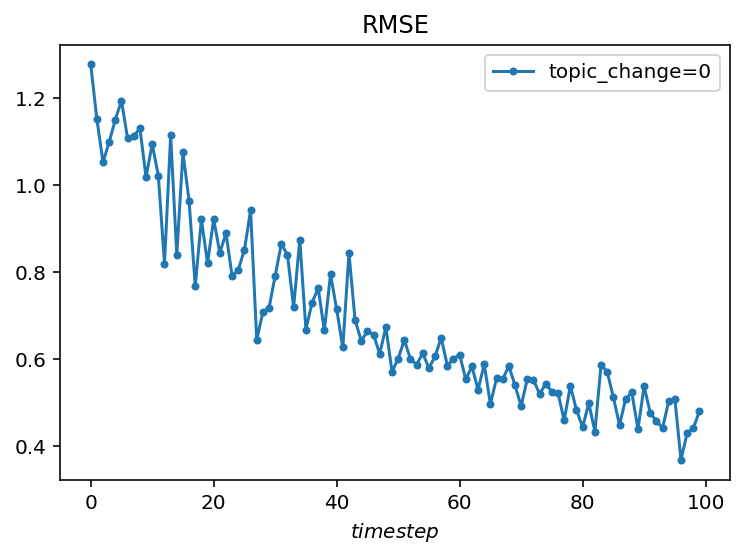

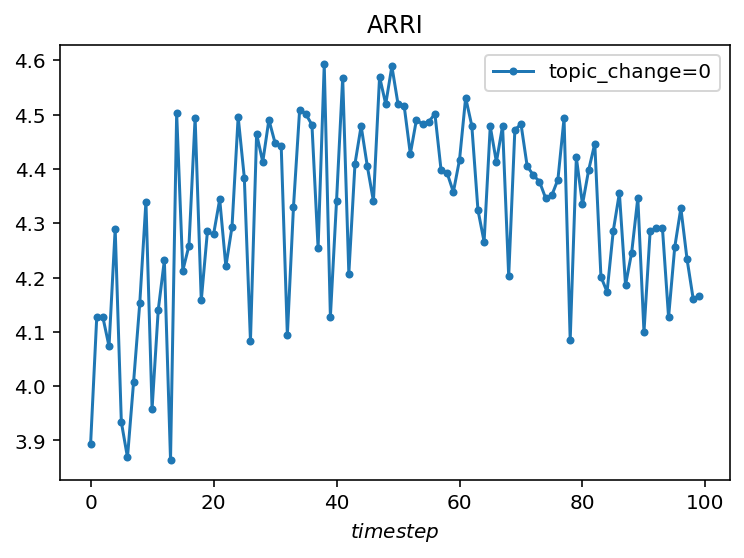

In [12]:
for k, v in res.items():
  plot_graphs(*list(v.values()), title=k, legend=True, label=['topic_change=0','topic_change=1','topic_change=2'], show=True, save=True)